<a href="https://colab.research.google.com/github/DhyeyMavani2003/dhyey-AIT-deep-learning-assignments-repo/blob/main/GAN_sequential_en_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright

<PRE>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.

Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
</PRE>

## Training GANs with sequential data
In this notebook, we show how to learn one-dimensional sequential data with Generative Adversarial Network (GAN) and how to generate patterns.

Please fill the \<TODO\> parts.

## Imports

In [3]:
import numpy as np
import copy
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

## Data
Create a superposed sine function with random noise - something similar, that can be seen on the figure:

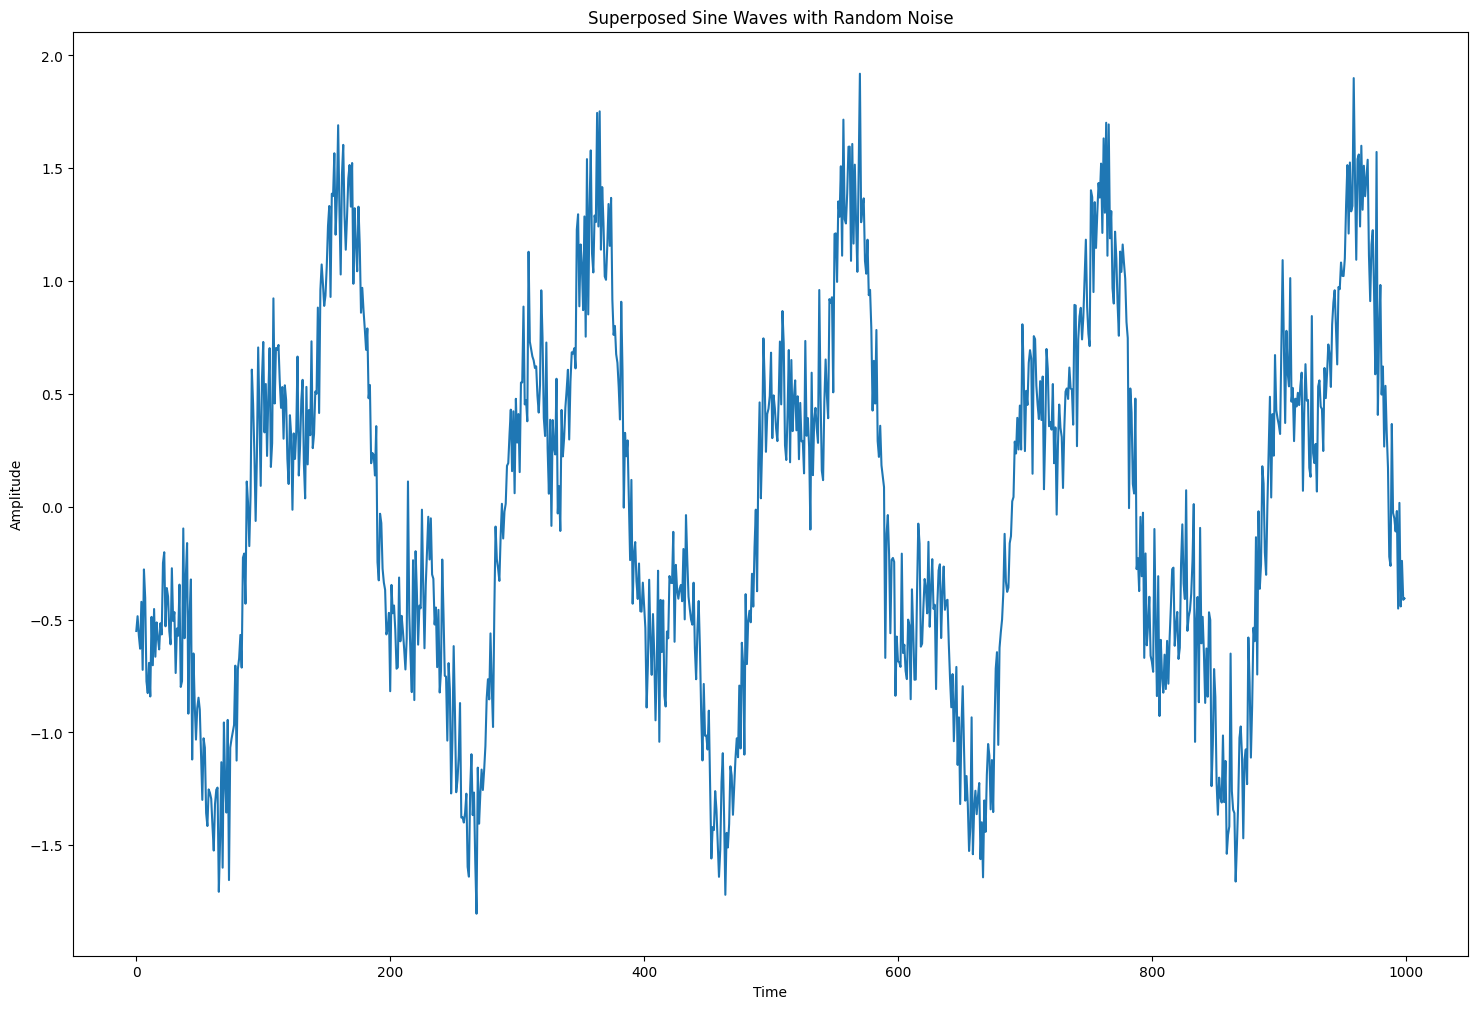

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
data_length = 1000
lp = np.linspace(-50 * np.pi, 50 * np.pi, data_length)  # Time vector
freq1 = 0.1  # Adjusted frequency of the first sine wave
freq2 = 0.3  # Adjusted frequency of the second sine wave
amplitude1 = 1  # Amplitude of the first sine wave
amplitude2 = 0.5  # Amplitude of the second sine wave
noise_amplitude = 0.2  # Amplitude of the random noise

# Generate the sine waves
sine_wave1 = amplitude1 * np.sin(freq1 * lp)
sine_wave2 = amplitude2 * np.cos(freq2 * lp)

# Superpose the sine waves
superposed_wave = sine_wave1 + sine_wave2

# Add random noise
noise = noise_amplitude * np.random.normal(size=lp.shape)
noisy_wave = superposed_wave + noise

# Assign to data
data = noisy_wave

# Plot the resulting wave
plt.figure(figsize=(18, 12))
plt.plot(data)
plt.title("Superposed Sine Waves with Random Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


Then prepare the three-dimensional data:

(960, 40, 1)


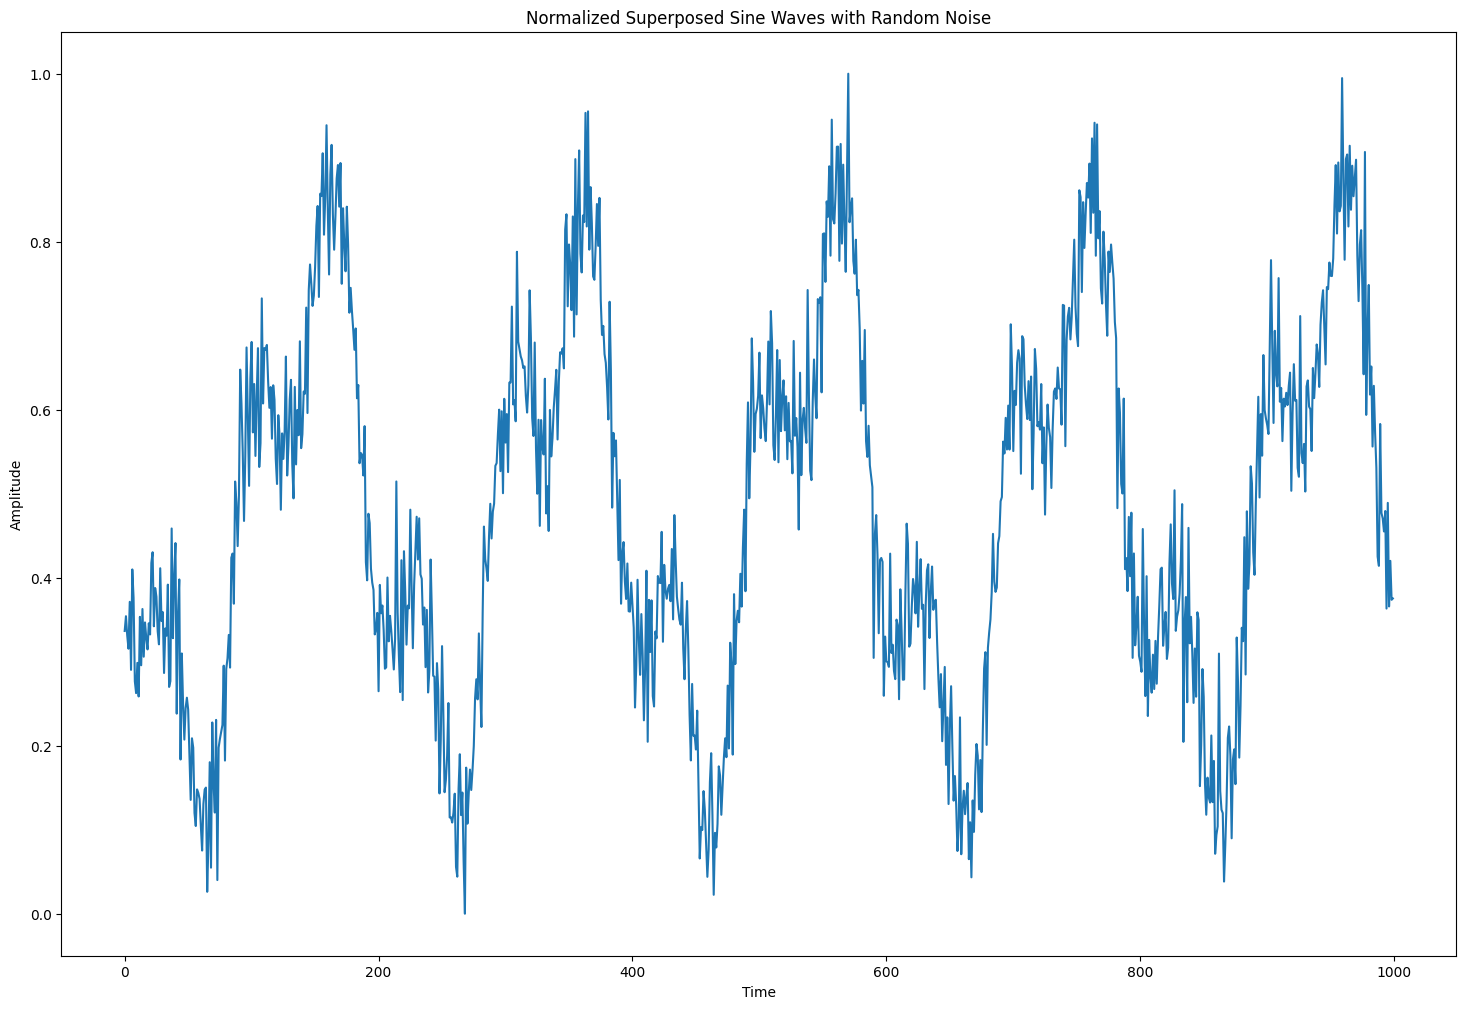

In [6]:
# Normalize the data to the 0...1 region
min_data = np.min(data)
max_data = np.max(data)
data = (data - min_data) / (max_data - min_data)

# Define the sliding window size
window_size = 40
X = np.array([data[start:start+window_size] for start in range(0, len(data)-window_size)])
X = np.atleast_3d(X)
print(X.shape)

# Plot the resulting wave
plt.figure(figsize=(18, 12))
plt.plot(data)
plt.title("Normalized Superposed Sine Waves with Random Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

## Model
Create the generator and the discriminator:

In [7]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, TimeDistributed
from keras.optimizers import Adam

adam_optim = Adam(0.0002, 0.5)

def define_generator(window_size, input_dim):
  model = Sequential()
  model.add(Conv1D(64, 3, input_shape=(window_size, input_dim), padding='same', activation='relu'))
  model.add(Conv1D(128, 3, padding='same', activation='relu'))
  model.add(Conv1D(256, 3, padding='same', activation='relu'))
  model.add(Conv1D(512, 3, padding='same', activation='relu'))
  model.add(TimeDistributed(Dense(input_dim, activation='linear')))
  return model

def define_discriminator(window_size, input_dim):
    model = Sequential()
    model.add(Conv1D(64, 3, input_shape=(window_size, input_dim), padding='same', activation='relu'))
    model.add(Conv1D(128, 3, padding='same', activation='relu'))
    model.add(Conv1D(256, 3, padding='same', activation='relu'))
    model.add(Conv1D(512, 3, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # the discriminator must be compiled to train it for classification
    model.compile(loss='binary_crossentropy', optimizer=adam_optim, metrics=['accuracy'])
    return model


Next, we create a function defining a GAN that connects the two (generator and discriminator) competing networks:

In [8]:
from keras.models import Model
from keras.layers import Input

def define_gan(generator, discriminator):
    # Make the discriminator not trainable when combined with the generator
    discriminator.trainable = False

    # Define the GAN input (noise) and the output
    gan_input = Input(shape=(generator.input_shape[1], generator.input_shape[2]))
    gen_output = generator(gan_input)
    gan_output = discriminator(gen_output)

    # Create the GAN model
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=adam_optim, metrics=['accuracy'])

    return gan


Then the real data and the noise generating functions are given:

In [9]:
# randomly take n samples from the data
# 1 is given as output
def get_real_samples(n, X):
    y = np.ones((n, 1))
    idx = np.random.randint(X.shape[0], size=n)
    return X[idx], y

# create noisy data
def generate_latent_points(n, window_size, features):
    x_input = np.random.randn(n*window_size * features)
    x_input = x_input.reshape(n, window_size, features)
    return x_input

# generate noisy data, prediction with the generator and
# output is set to 0
def get_fake_samples(generator, n, window_size, features):
    x_input = generate_latent_points(n, window_size, features)
    x_latent = generator.predict(x_input)
    y = np.zeros((n, 1))
    return x_latent, y

The function that monitor the performance of GAN numerically and also visualizes it.

In [10]:
def summarize_performance(epoch, generator, discriminator, X, window_size, n=100):
    # Evaluation on real data
    x_real, y_real = get_real_samples(n, X)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)

    # Evaluation on fake data
    x_fake, y_fake = get_fake_samples(generator, n, window_size, X.shape[2])
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

    print(epoch, "epoch, Recognizing real data:", acc_real, ", Recognizing fake data:", acc_fake)

    # Visualize the samples
    plt.figure(figsize=(12, 6))
    for i in range(min(5, x_real.shape[0])):  # Plotting only 5 samples for clarity
        plt.plot(x_real[i, :, 0], color='red', alpha=0.6, label='Real' if i == 0 else "")
        plt.plot(x_fake[i, :, 0], color='blue', alpha=0.6, label='Fake' if i == 0 else "")
    plt.ylim(-1, 5)
    plt.xlim(0, window_size)
    plt.legend()
    plt.show()

    return acc_real, acc_fake

The model is defined in two steps: first, we construct a learnable discriminator, and second, we incorporate the discriminator with frozen weights into the full GAN:

In [11]:
patience       = 20
batch_size     = 256
nb_epochs      = 10000
input_dim      = X.shape[-1]

model_gen     = define_generator(window_size, 1)
model_dis     = define_discriminator(window_size, 1)

frozen_discriminator = Model(model_dis.inputs, model_dis.outputs)
frozen_discriminator.trainable = False
# create the gan
model_gan = define_gan(model_gen, frozen_discriminator)

In [12]:
print(model_gen.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 64)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           24704     
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 256)           98560     
                                                                 
 conv1d_3 (Conv1D)           (None, 40, 512)           393728    
                                                                 
 time_distributed (TimeDist  (None, 40, 1)             513       
 ributed)                                                        
                                                                 
Total params: 517761 (1.98 MB)
Trainable params: 517761 (1.98 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [13]:
print(model_dis.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 40, 64)            256       
                                                                 
 conv1d_5 (Conv1D)           (None, 40, 128)           24704     
                                                                 
 conv1d_6 (Conv1D)           (None, 40, 256)           98560     
                                                                 
 conv1d_7 (Conv1D)           (None, 40, 512)           393728    
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 20481     
                                                                 
Total params: 537729 (2.05 MB)
Trainable params: 0 (0.

## Training the network
The GAN is trained in two steps:
* first, the discriminator is trained to distinguish between real and fake data.
* then, with the discriminator weights frozen, we train the generator part of the entire network to transform the noise so that the discriminator considers it to be real data.

4/4 [==============================] - 0s 4ms/step
0 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


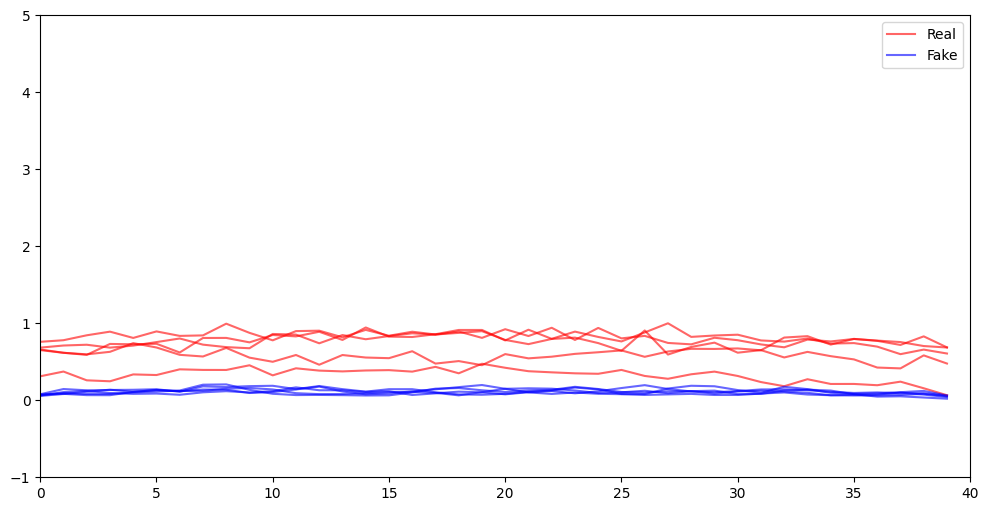

4/4 [==============================] - 0s 6ms/step
10 epoch, Recognizing real data: 0.0 , Recognizing fake data: 1.0


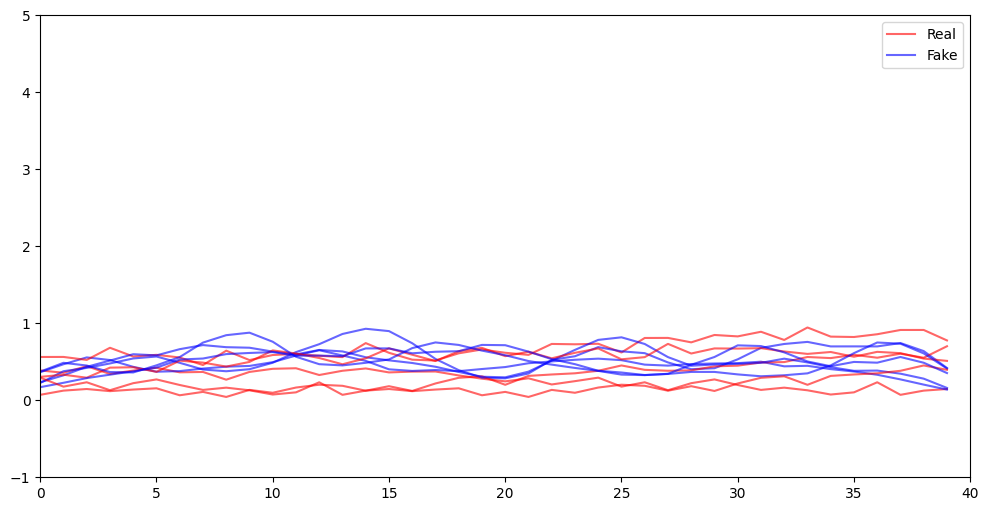

4/4 [==============================] - 0s 4ms/step
20 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


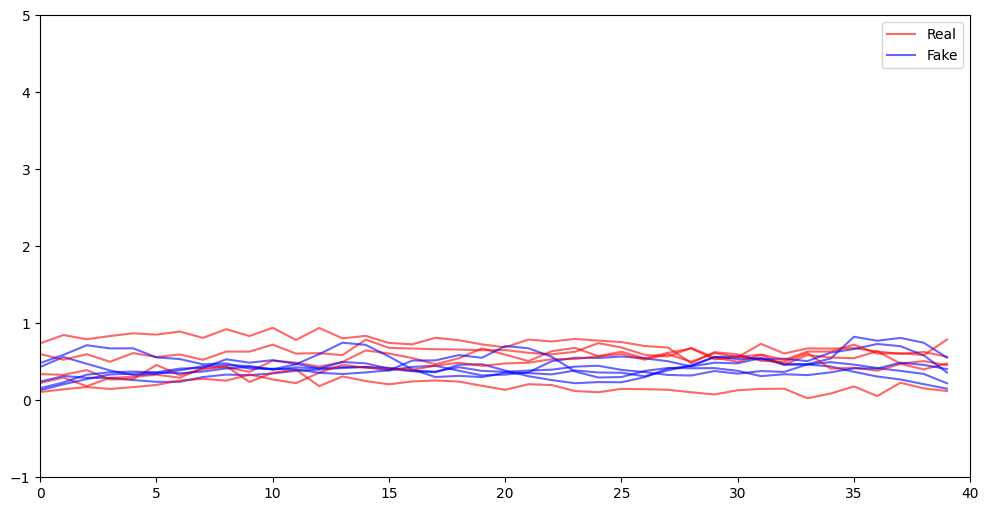

4/4 [==============================] - 0s 4ms/step
30 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


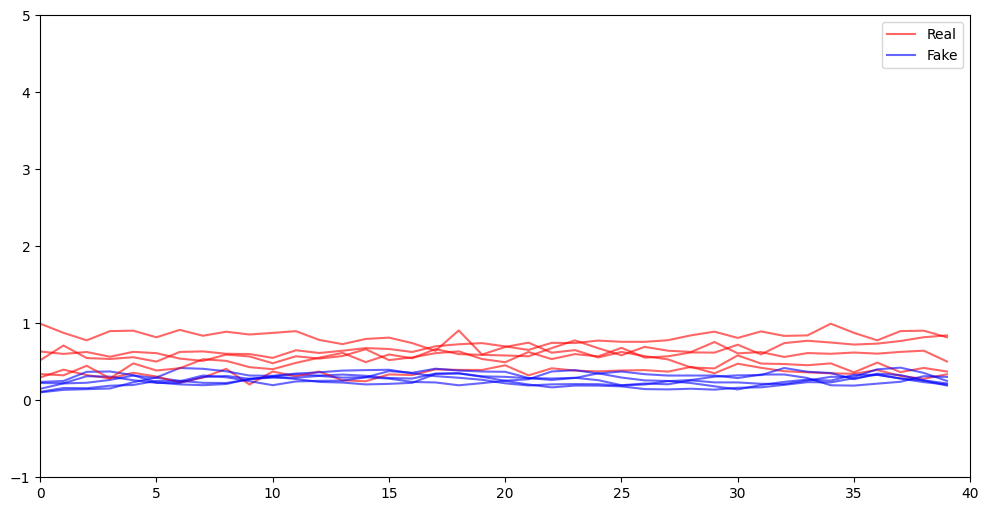

4/4 [==============================] - 0s 7ms/step
40 epoch, Recognizing real data: 0.28999999165534973 , Recognizing fake data: 0.8299999833106995


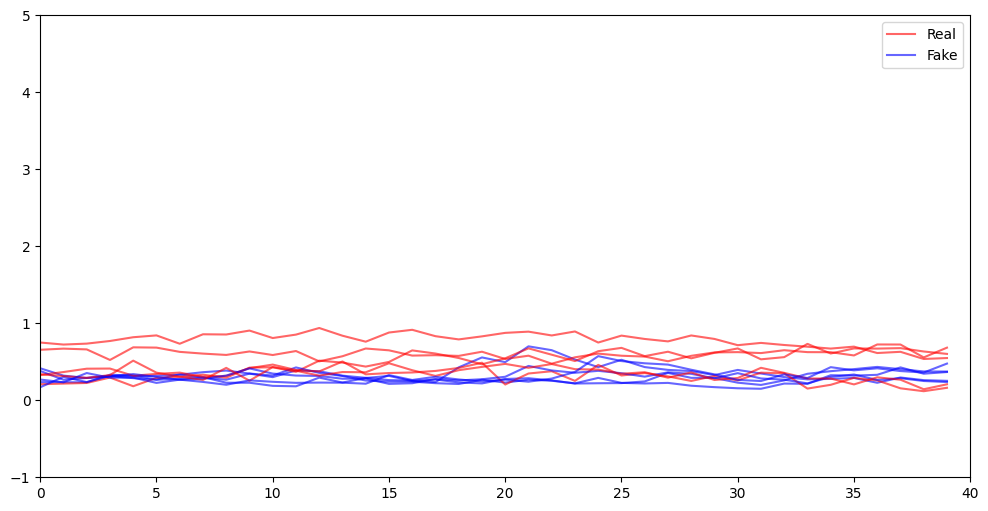

4/4 [==============================] - 0s 4ms/step
50 epoch, Recognizing real data: 0.0 , Recognizing fake data: 1.0


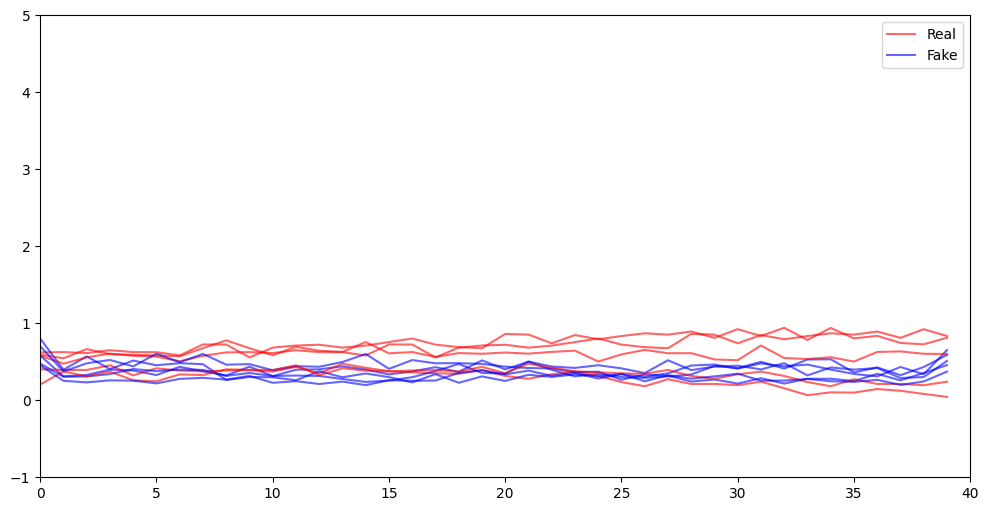

4/4 [==============================] - 0s 4ms/step
60 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


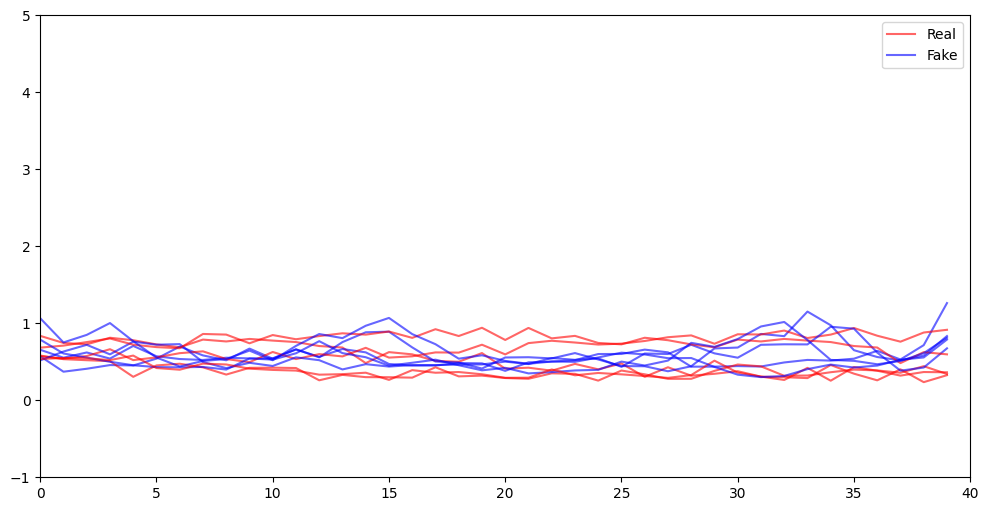

4/4 [==============================] - 0s 4ms/step
70 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


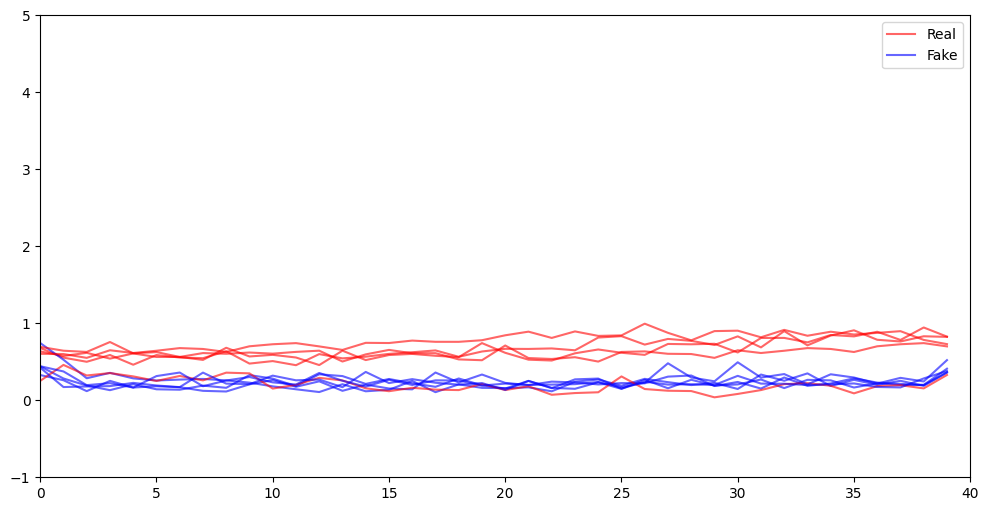

4/4 [==============================] - 0s 4ms/step
80 epoch, Recognizing real data: 0.05999999865889549 , Recognizing fake data: 1.0


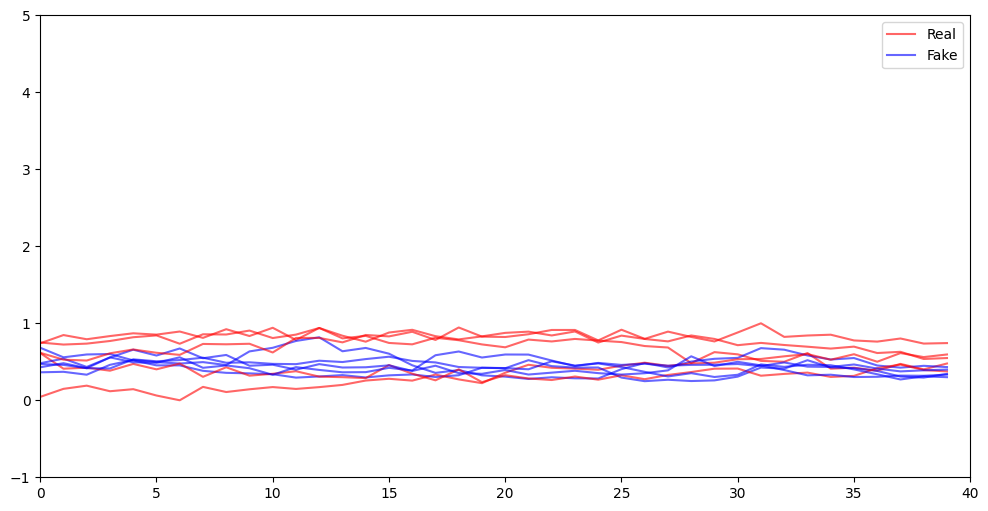

4/4 [==============================] - 0s 8ms/step
90 epoch, Recognizing real data: 0.07999999821186066 , Recognizing fake data: 1.0


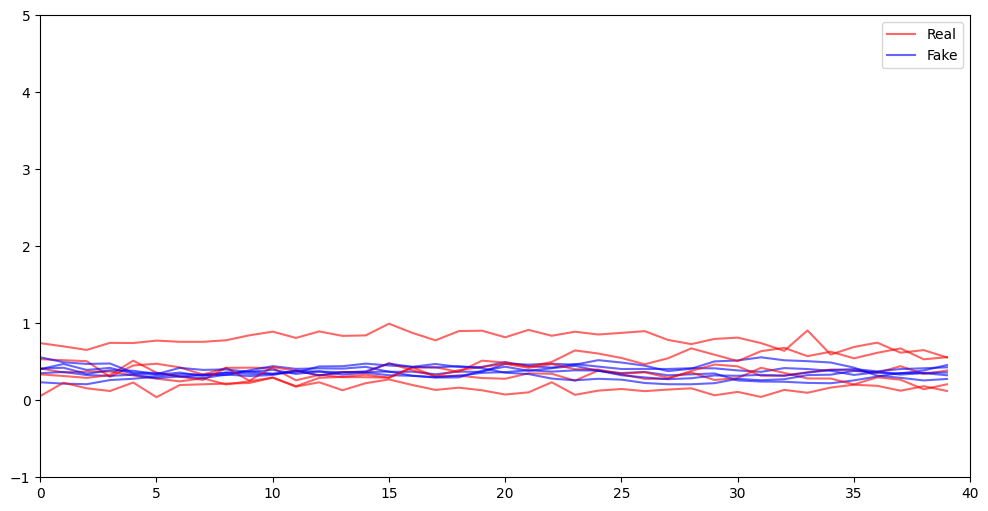

4/4 [==============================] - 0s 4ms/step
100 epoch, Recognizing real data: 0.0 , Recognizing fake data: 1.0


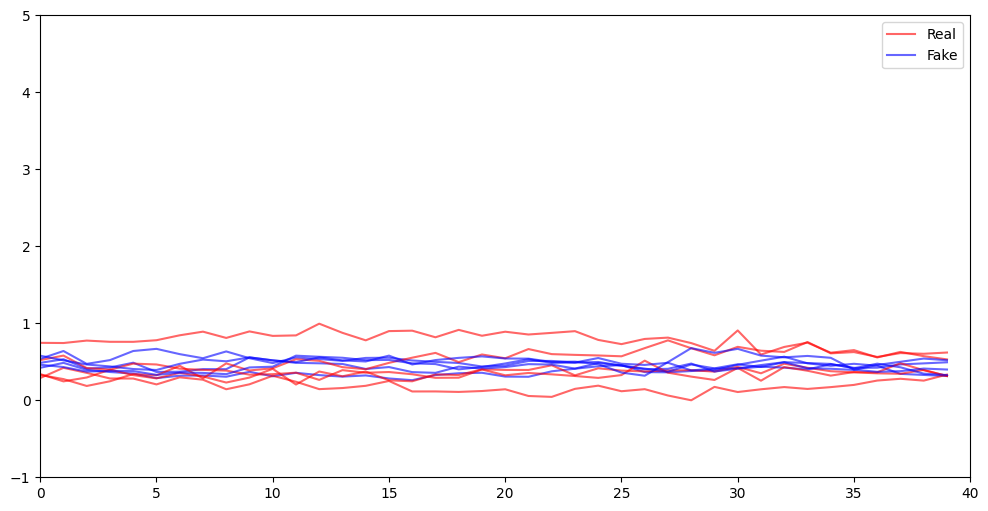

4/4 [==============================] - 0s 4ms/step
110 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


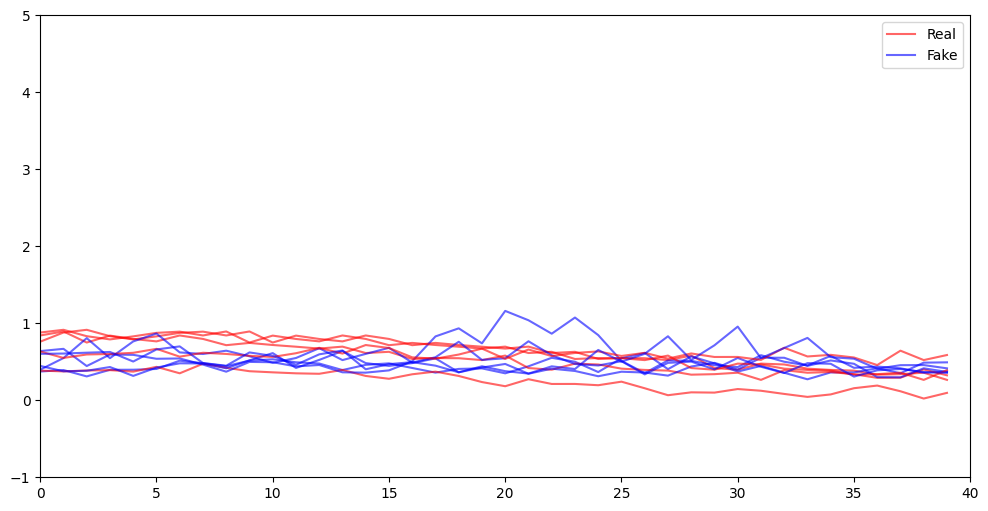

4/4 [==============================] - 0s 4ms/step
120 epoch, Recognizing real data: 0.5600000023841858 , Recognizing fake data: 1.0


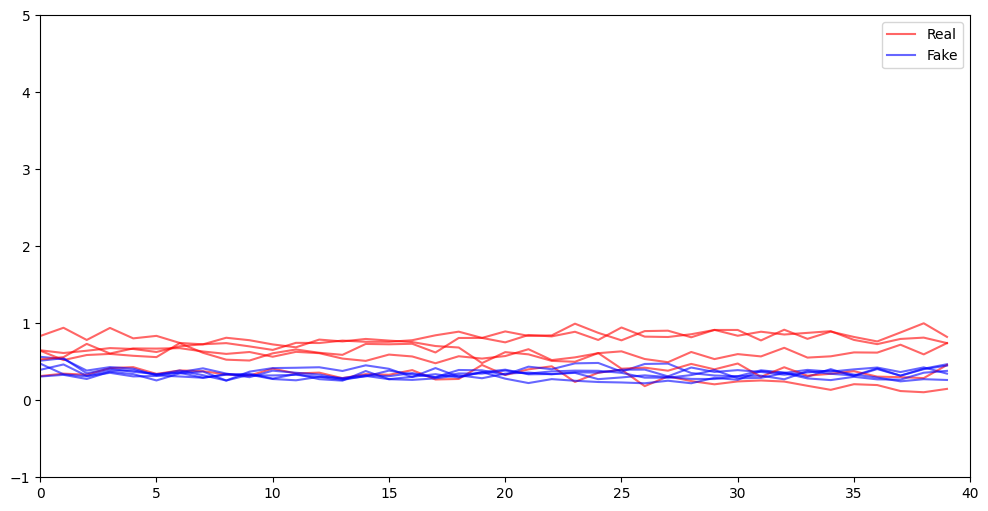

4/4 [==============================] - 0s 5ms/step
130 epoch, Recognizing real data: 0.7300000190734863 , Recognizing fake data: 0.6100000143051147


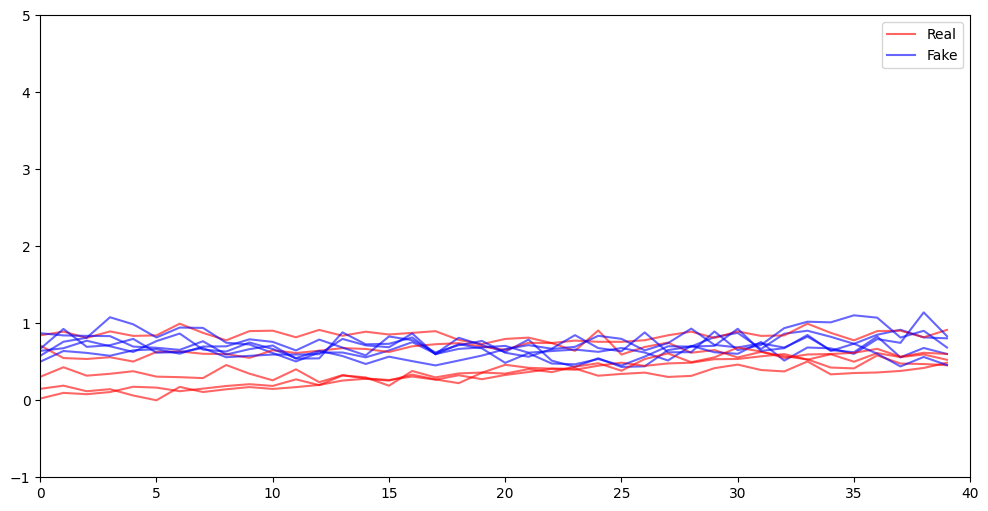

4/4 [==============================] - 0s 5ms/step
140 epoch, Recognizing real data: 0.38999998569488525 , Recognizing fake data: 1.0


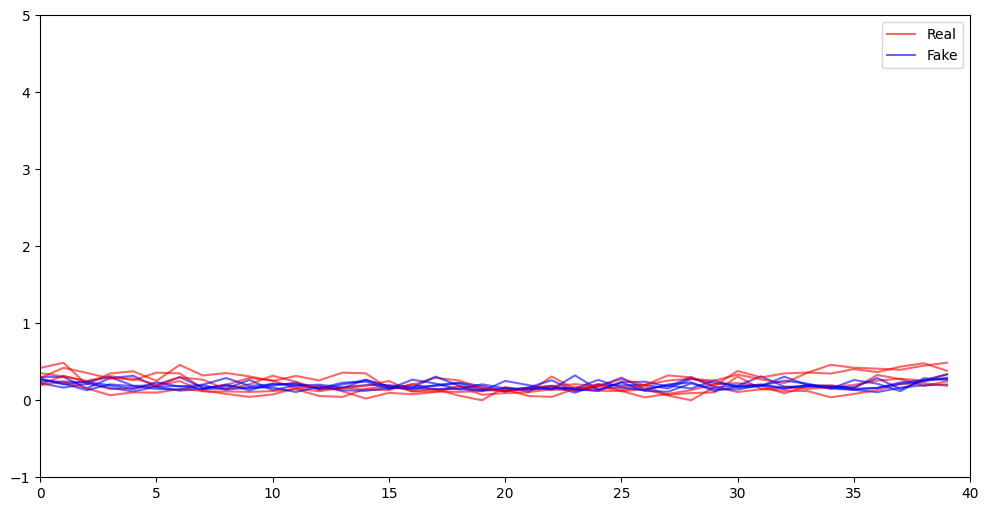

4/4 [==============================] - 0s 4ms/step
150 epoch, Recognizing real data: 0.6899999976158142 , Recognizing fake data: 0.3400000035762787


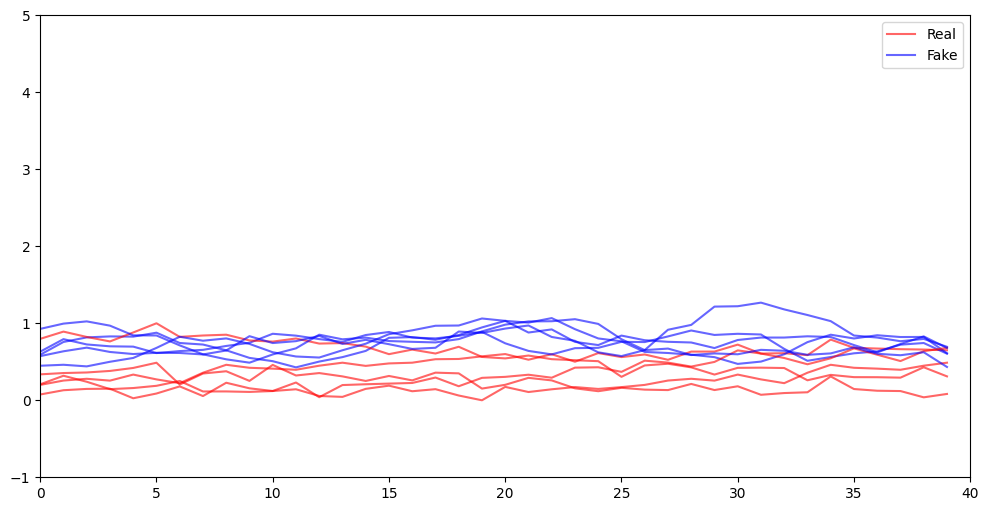

4/4 [==============================] - 0s 4ms/step
160 epoch, Recognizing real data: 0.5899999737739563 , Recognizing fake data: 1.0


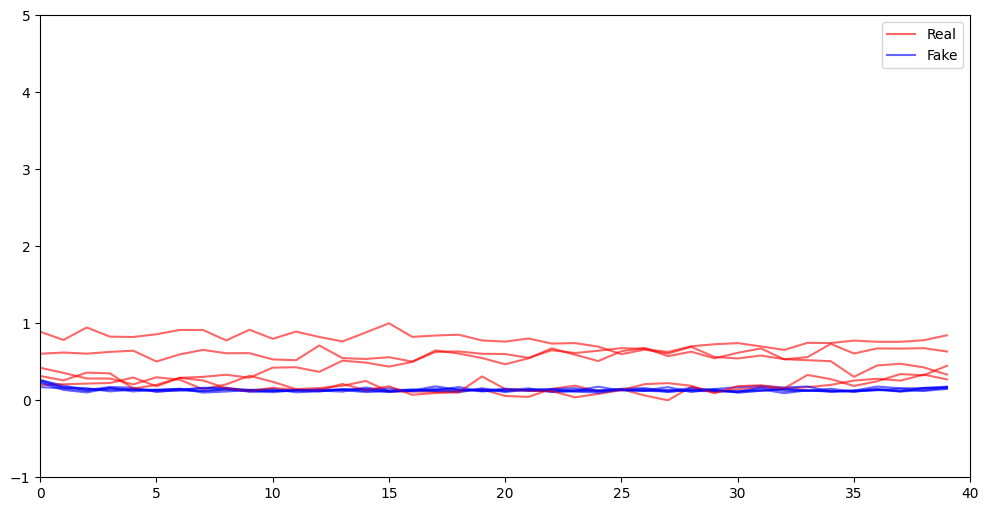

4/4 [==============================] - 0s 8ms/step
170 epoch, Recognizing real data: 0.7699999809265137 , Recognizing fake data: 0.019999999552965164


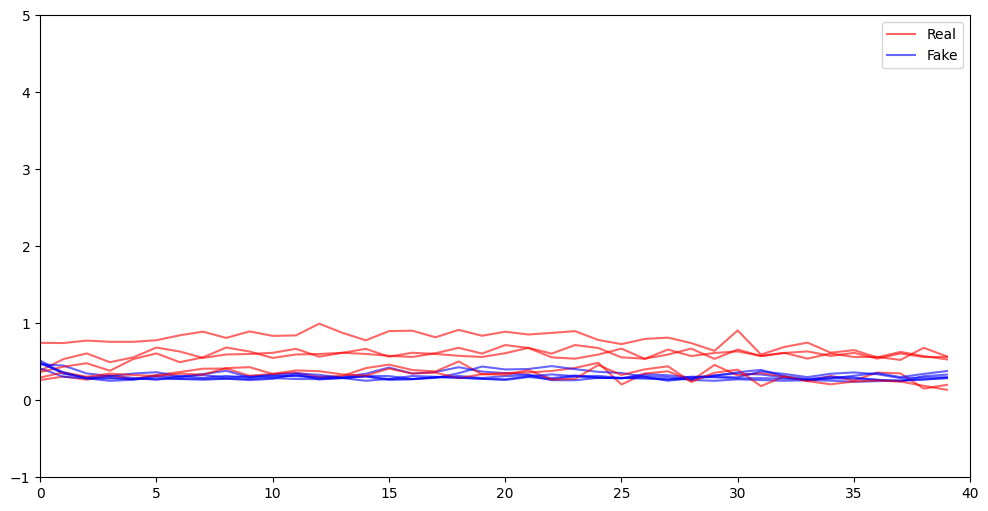

4/4 [==============================] - 0s 4ms/step
180 epoch, Recognizing real data: 0.8999999761581421 , Recognizing fake data: 0.0


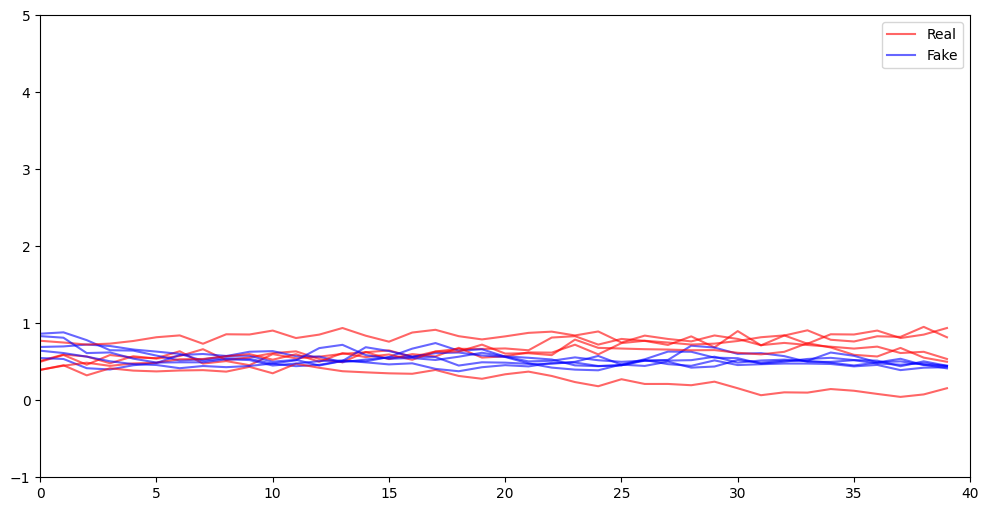

4/4 [==============================] - 0s 4ms/step
190 epoch, Recognizing real data: 0.7699999809265137 , Recognizing fake data: 0.0


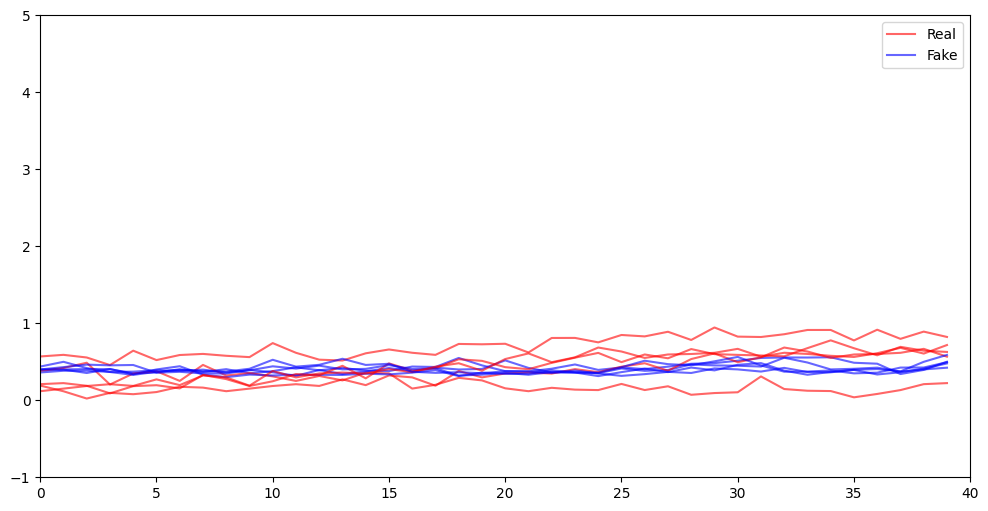

4/4 [==============================] - 0s 4ms/step
200 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


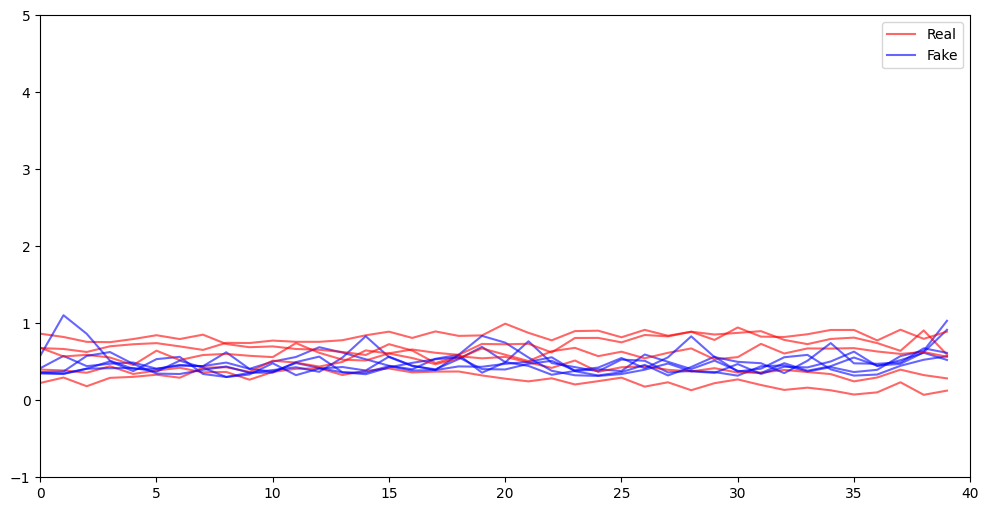

4/4 [==============================] - 0s 5ms/step
210 epoch, Recognizing real data: 0.33000001311302185 , Recognizing fake data: 1.0


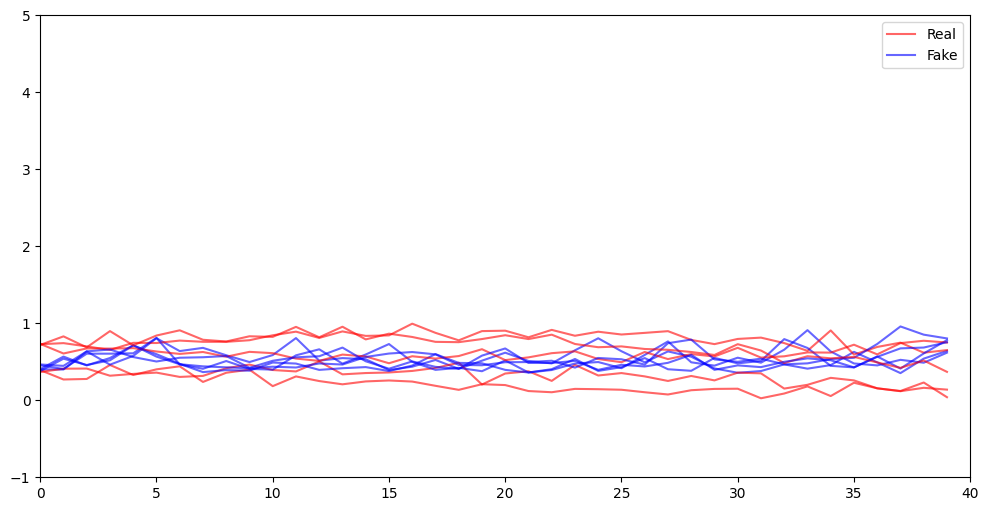

4/4 [==============================] - 0s 4ms/step
220 epoch, Recognizing real data: 0.3100000023841858 , Recognizing fake data: 1.0


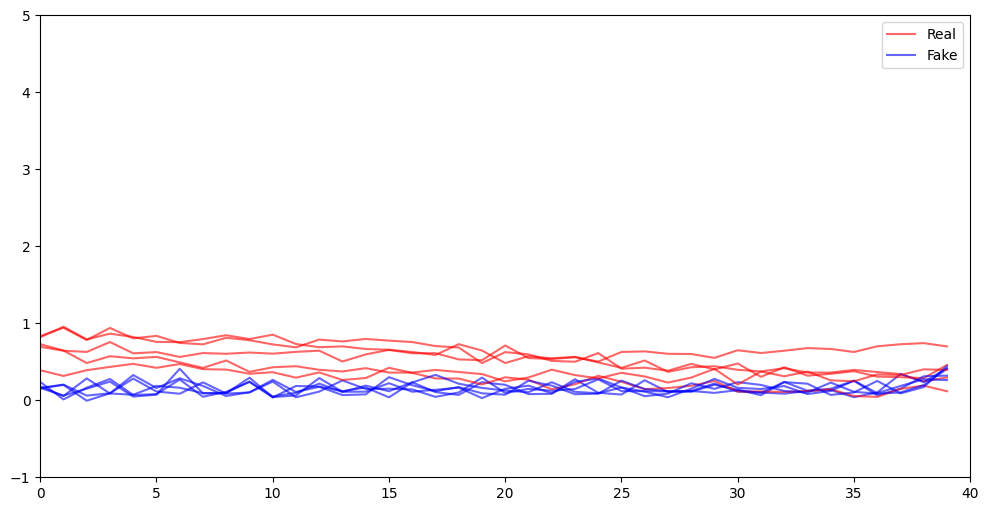

4/4 [==============================] - 0s 4ms/step
230 epoch, Recognizing real data: 0.41999998688697815 , Recognizing fake data: 0.44999998807907104


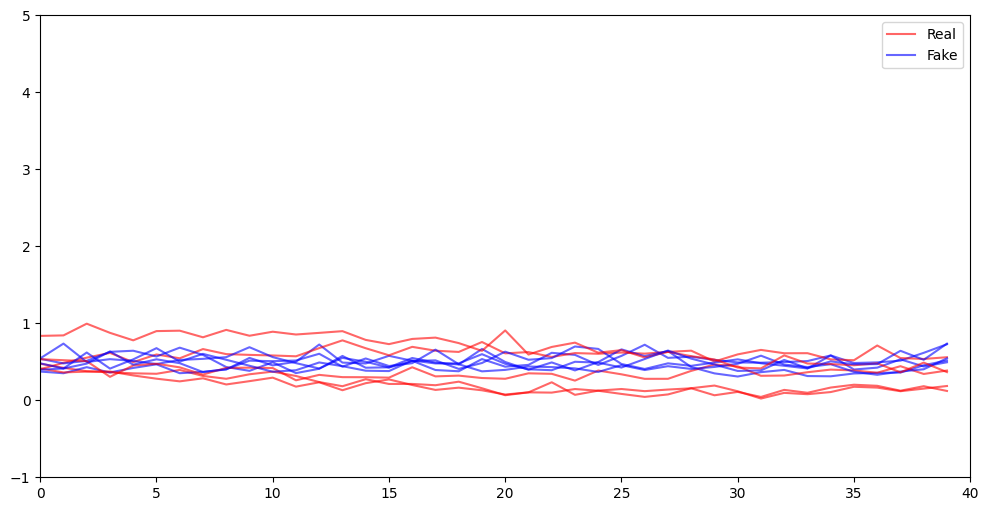

4/4 [==============================] - 0s 8ms/step
240 epoch, Recognizing real data: 0.0 , Recognizing fake data: 1.0


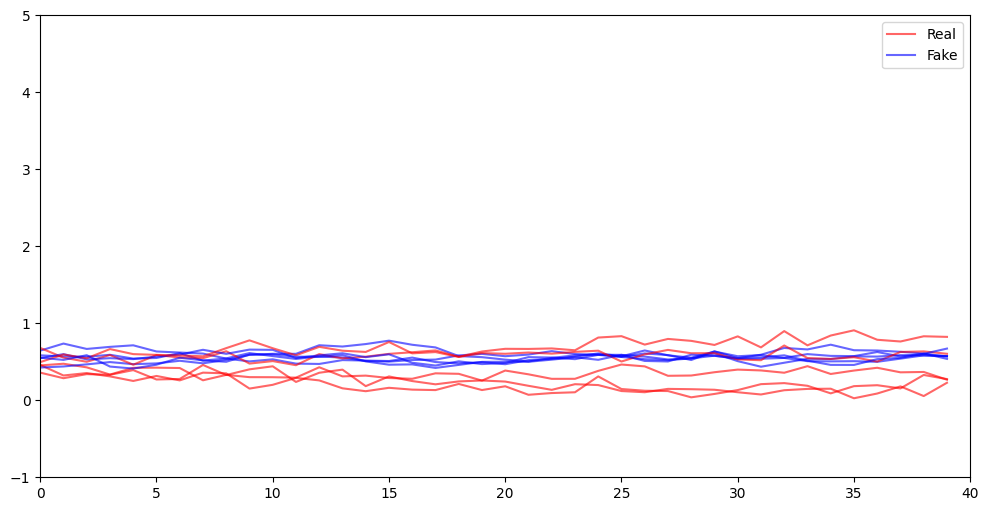

4/4 [==============================] - 0s 5ms/step
250 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


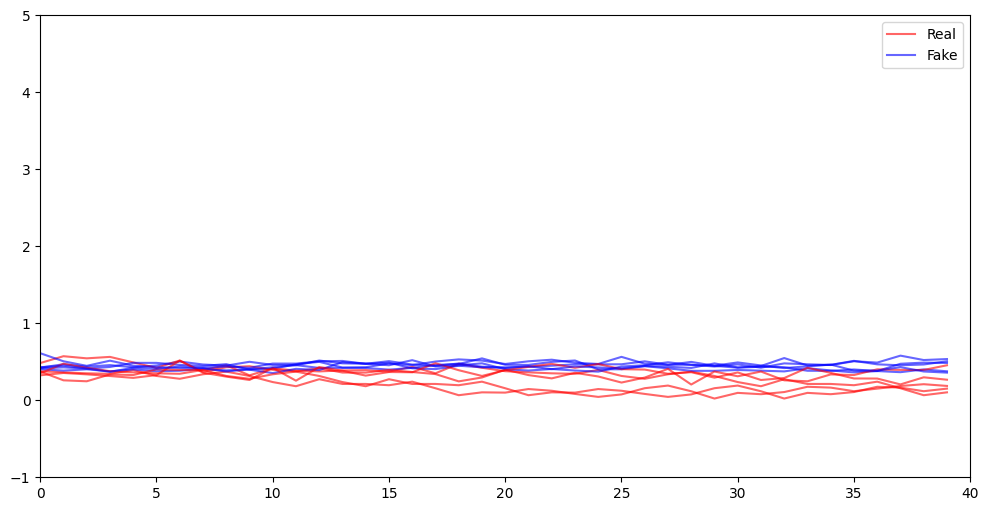

4/4 [==============================] - 0s 3ms/step
260 epoch, Recognizing real data: 0.25 , Recognizing fake data: 1.0


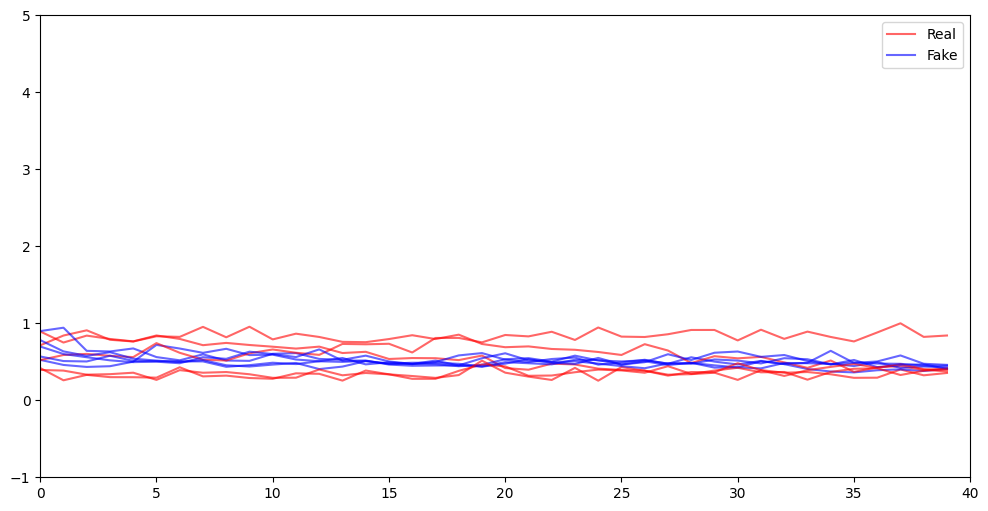

4/4 [==============================] - 0s 6ms/step
270 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


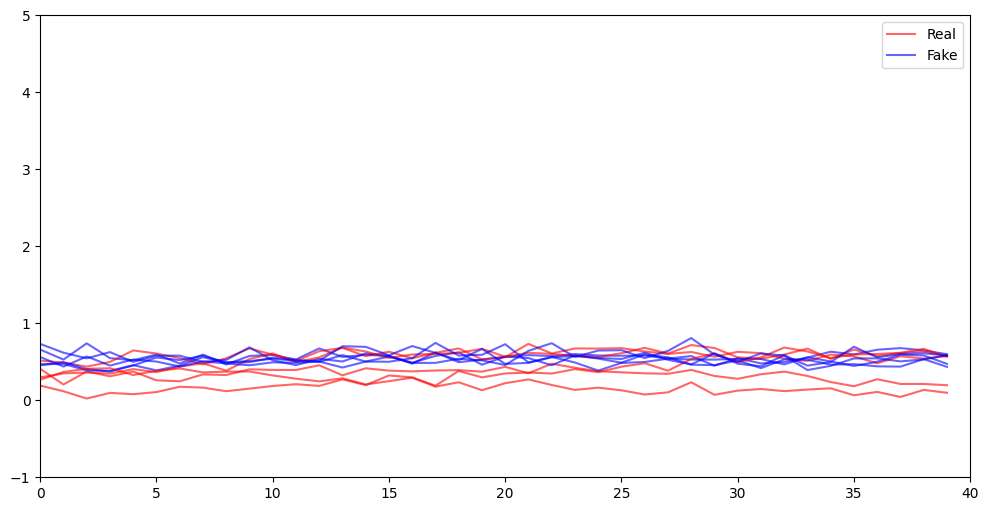

4/4 [==============================] - 0s 4ms/step
280 epoch, Recognizing real data: 0.5899999737739563 , Recognizing fake data: 1.0


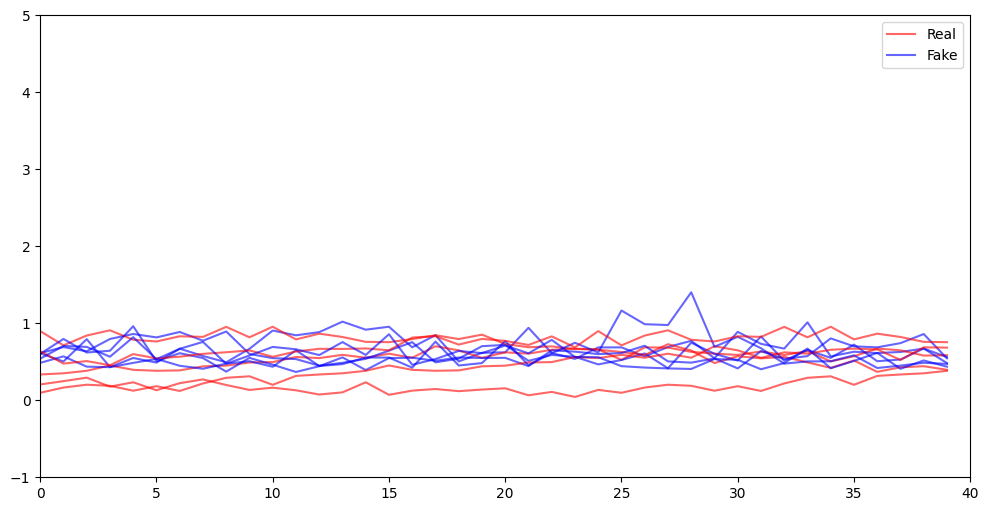

4/4 [==============================] - 0s 3ms/step
290 epoch, Recognizing real data: 0.550000011920929 , Recognizing fake data: 0.9599999785423279


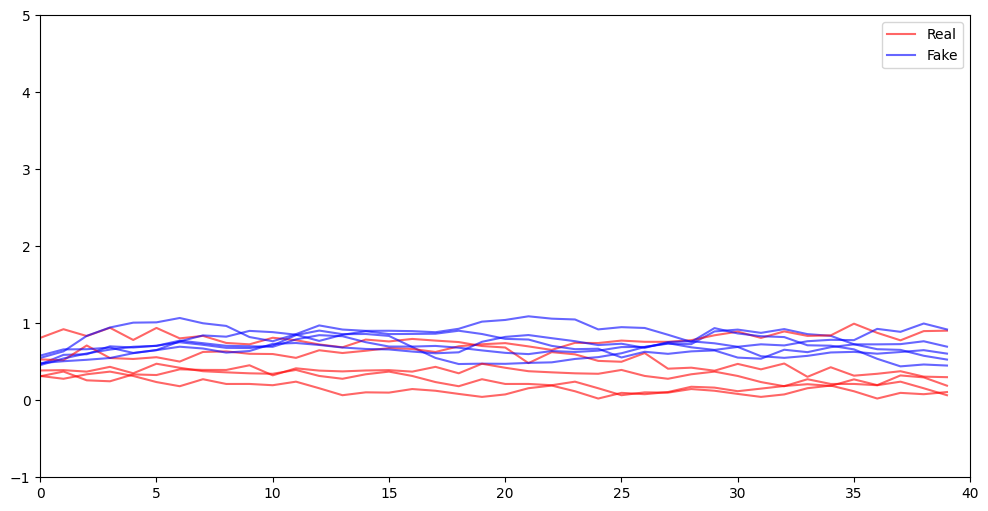

4/4 [==============================] - 0s 3ms/step
300 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.019999999552965164


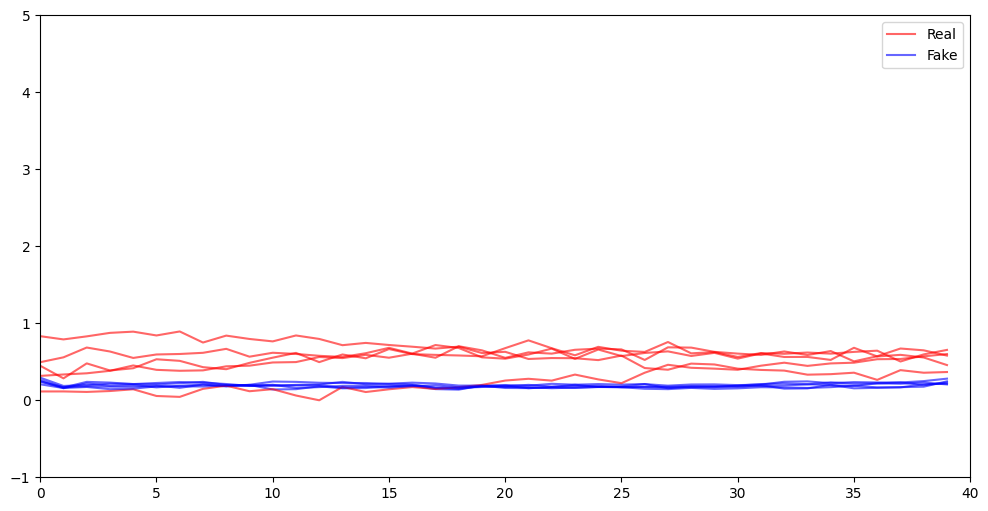

4/4 [==============================] - 0s 8ms/step
310 epoch, Recognizing real data: 0.05999999865889549 , Recognizing fake data: 1.0


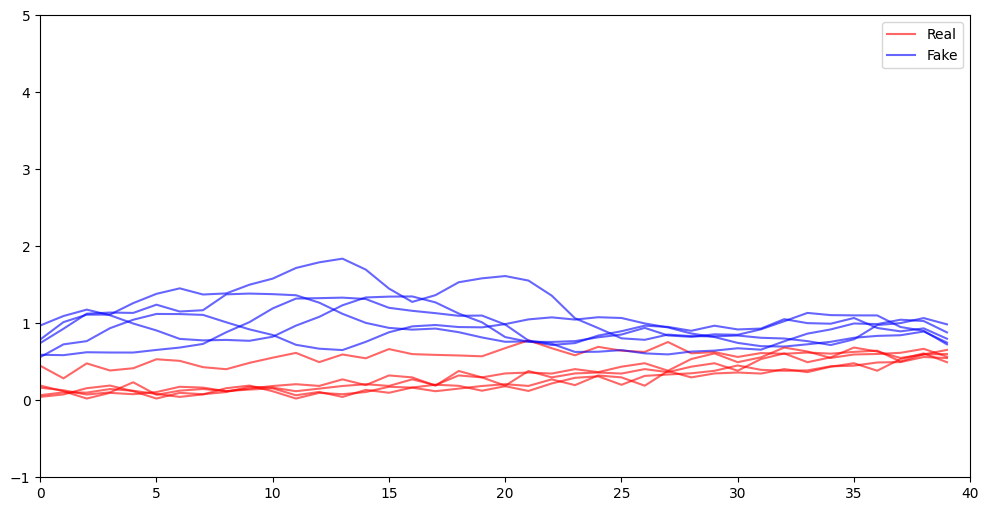

4/4 [==============================] - 0s 3ms/step
320 epoch, Recognizing real data: 0.3700000047683716 , Recognizing fake data: 1.0


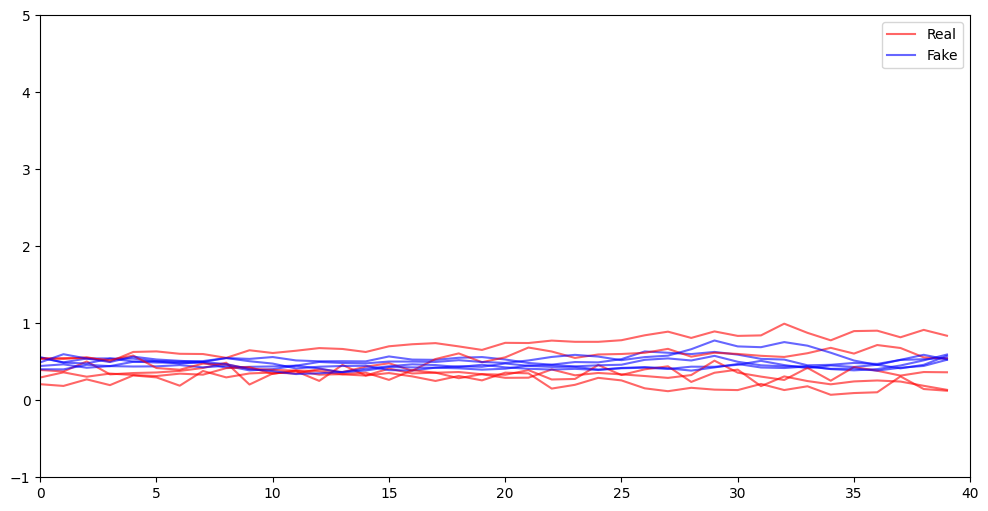

4/4 [==============================] - 0s 4ms/step
330 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.6100000143051147


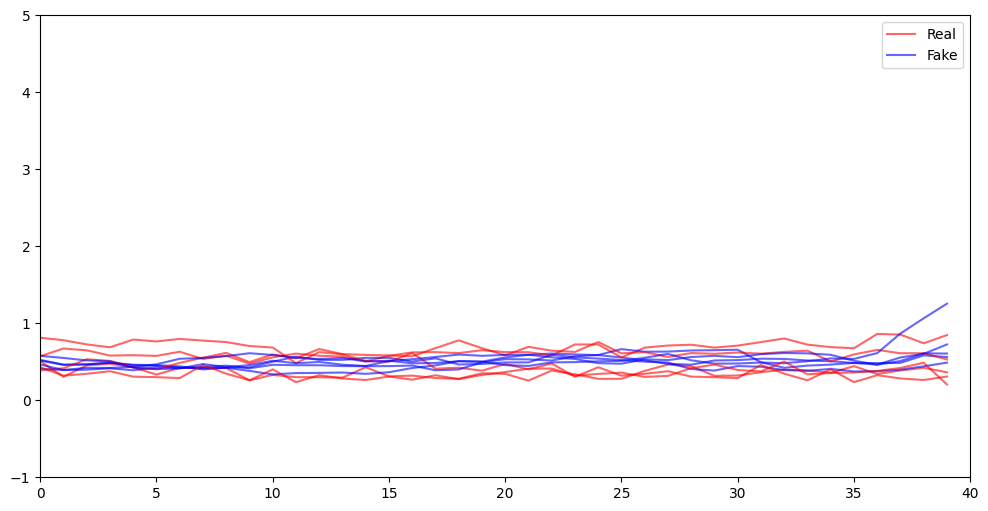

4/4 [==============================] - 0s 5ms/step
340 epoch, Recognizing real data: 0.47999998927116394 , Recognizing fake data: 0.9900000095367432


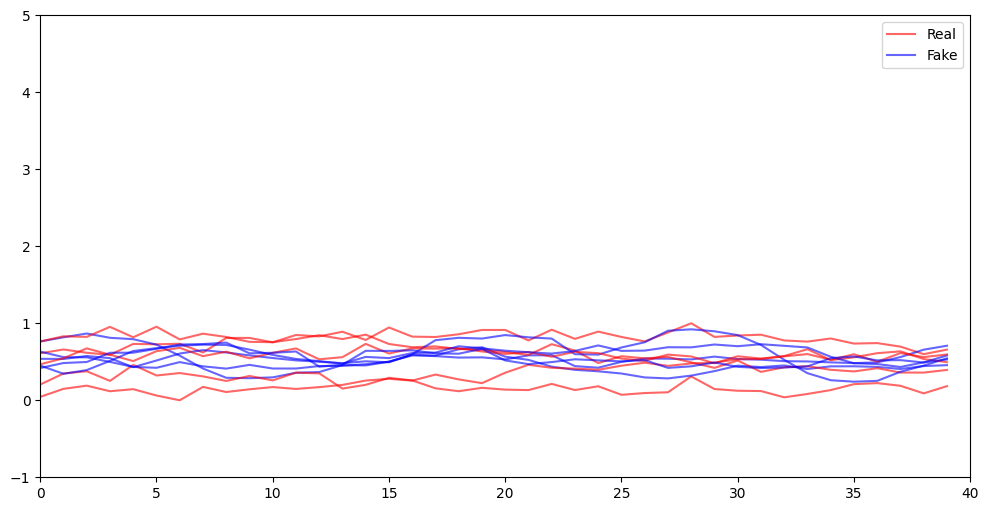

4/4 [==============================] - 0s 3ms/step
350 epoch, Recognizing real data: 0.8399999737739563 , Recognizing fake data: 0.3199999928474426


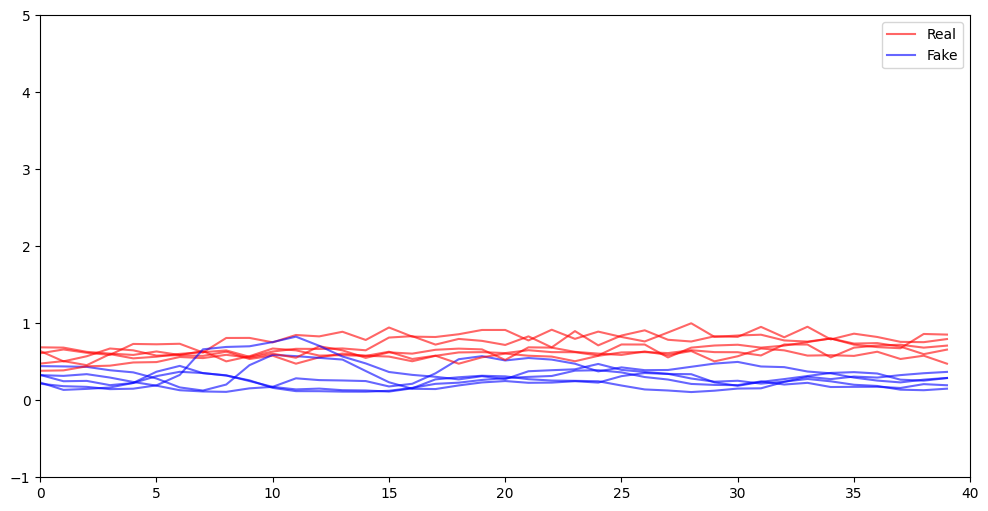

4/4 [==============================] - 0s 4ms/step
360 epoch, Recognizing real data: 0.6499999761581421 , Recognizing fake data: 0.0


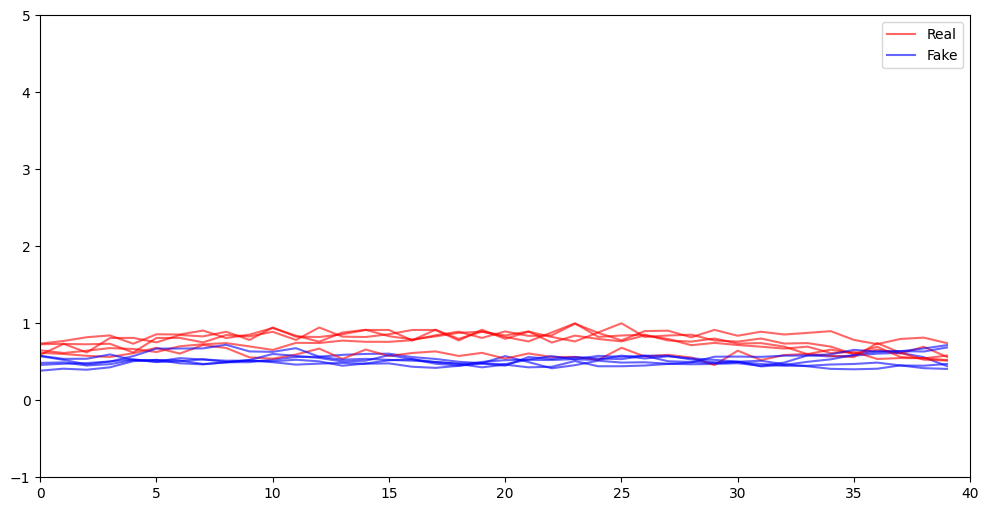

4/4 [==============================] - 0s 4ms/step
370 epoch, Recognizing real data: 0.28999999165534973 , Recognizing fake data: 0.9300000071525574


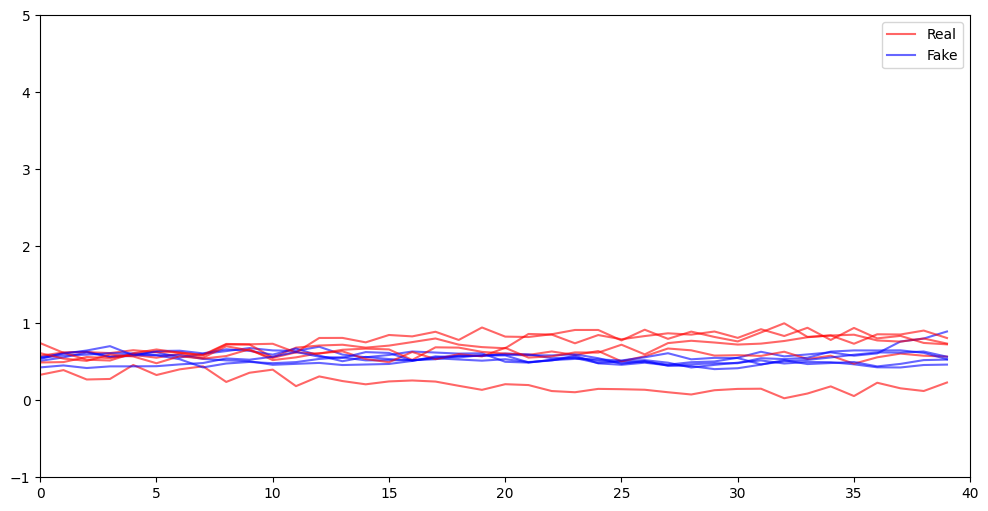

4/4 [==============================] - 0s 3ms/step
380 epoch, Recognizing real data: 0.25 , Recognizing fake data: 1.0


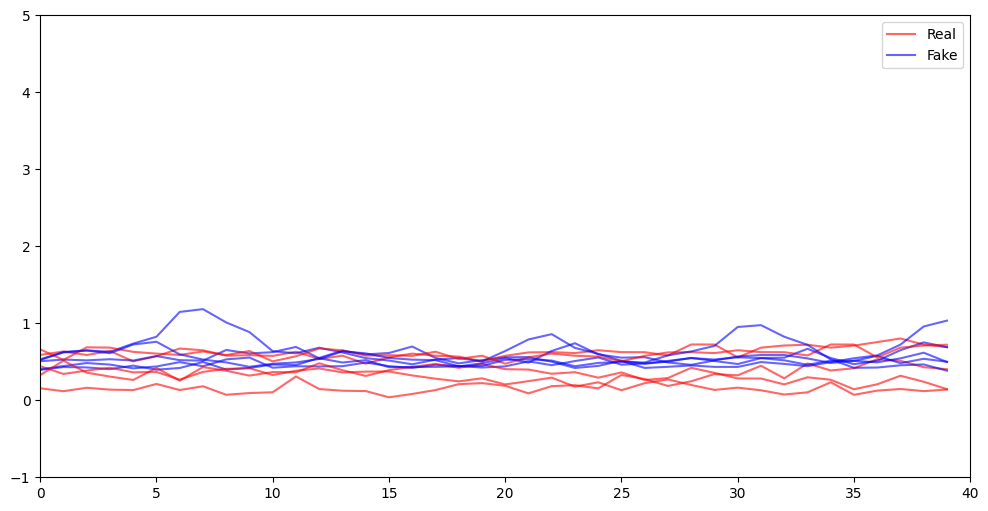

4/4 [==============================] - 0s 4ms/step
390 epoch, Recognizing real data: 0.23999999463558197 , Recognizing fake data: 1.0


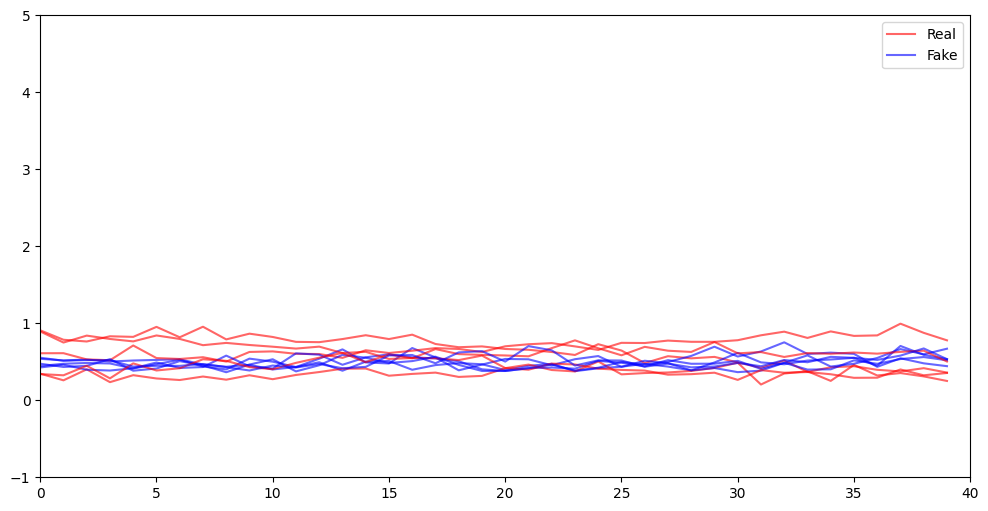

4/4 [==============================] - 0s 3ms/step
400 epoch, Recognizing real data: 0.6499999761581421 , Recognizing fake data: 0.9800000190734863


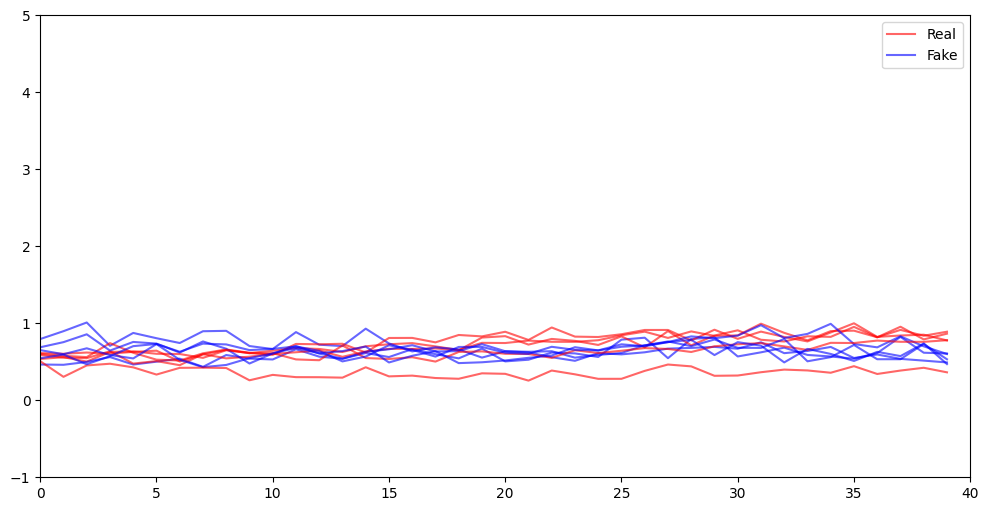

4/4 [==============================] - 0s 3ms/step
410 epoch, Recognizing real data: 0.6600000262260437 , Recognizing fake data: 1.0


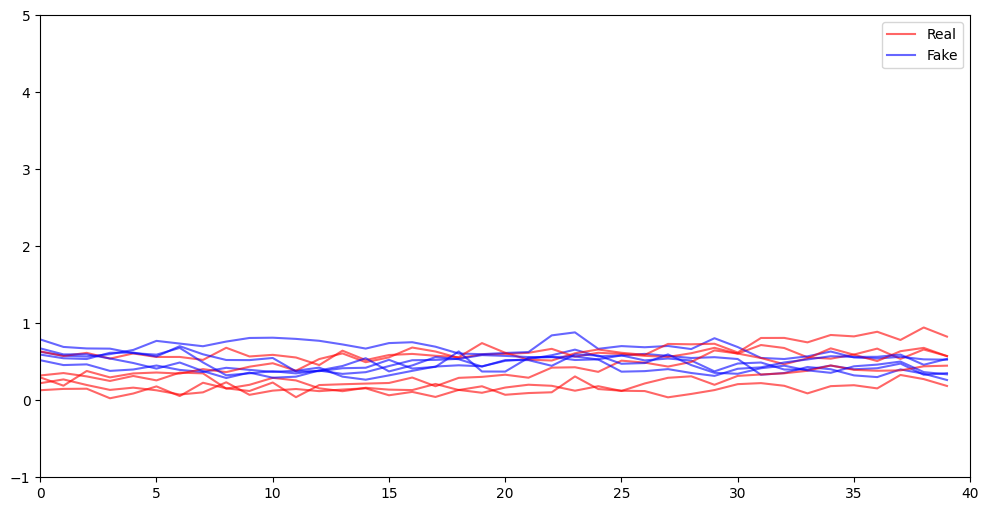

4/4 [==============================] - 0s 4ms/step
420 epoch, Recognizing real data: 0.33000001311302185 , Recognizing fake data: 1.0


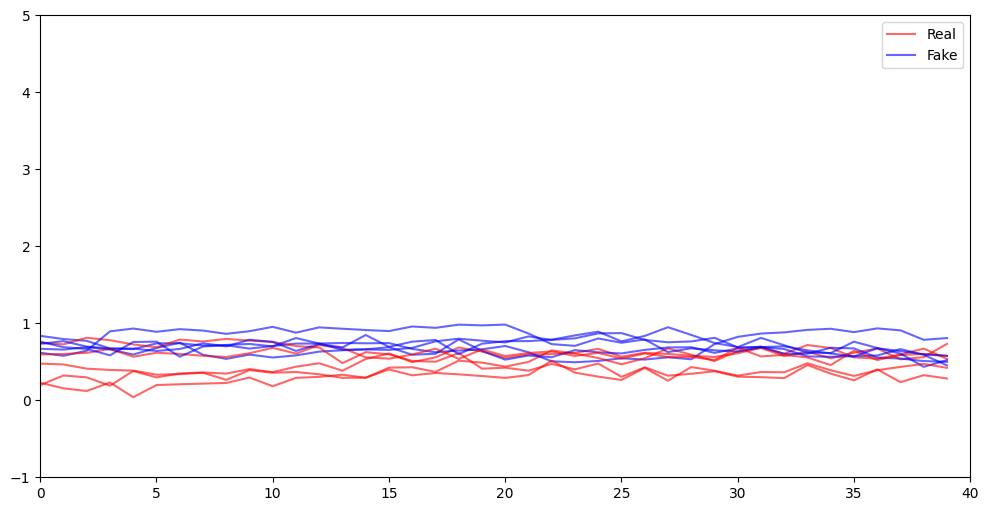

4/4 [==============================] - 0s 4ms/step
430 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


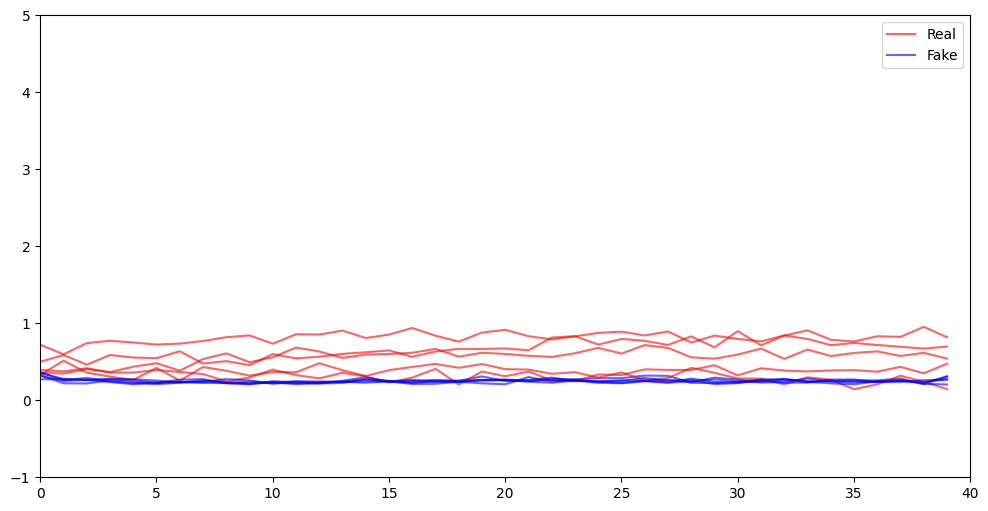

4/4 [==============================] - 0s 3ms/step
440 epoch, Recognizing real data: 0.949999988079071 , Recognizing fake data: 1.0


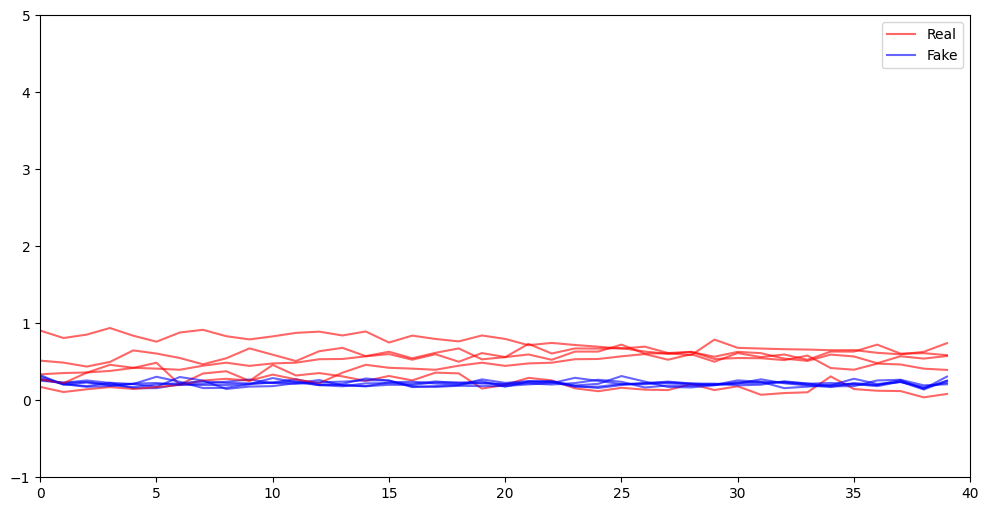

4/4 [==============================] - 0s 4ms/step
450 epoch, Recognizing real data: 0.0 , Recognizing fake data: 0.9900000095367432


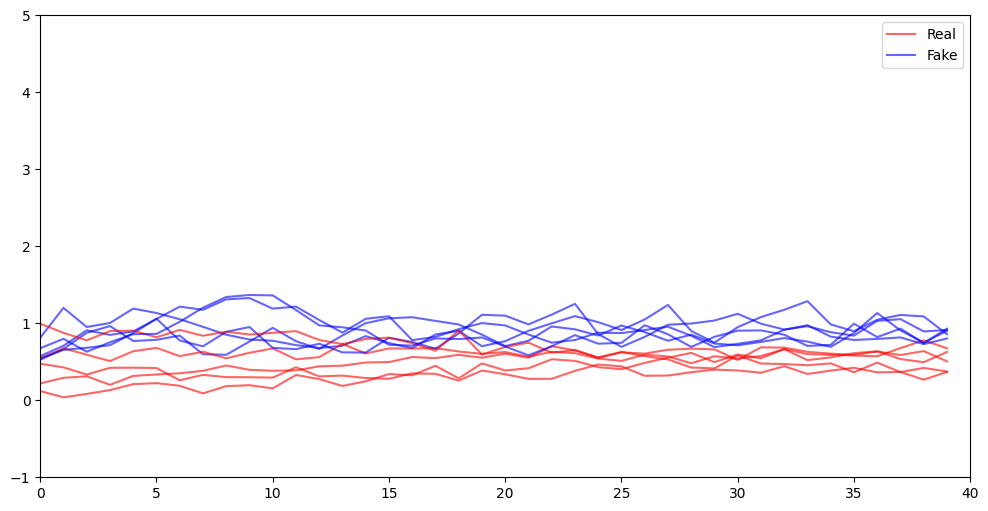

4/4 [==============================] - 0s 3ms/step
460 epoch, Recognizing real data: 0.8299999833106995 , Recognizing fake data: 0.9200000166893005


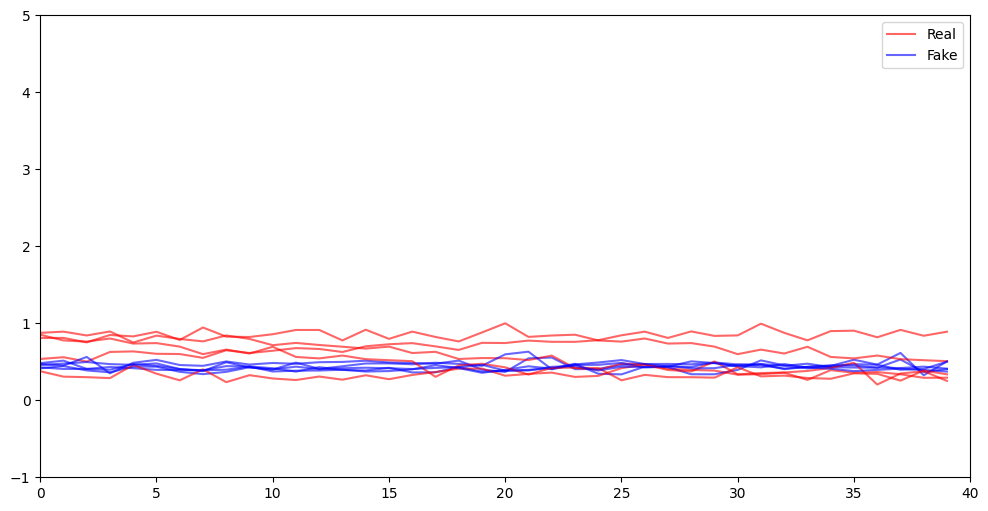

4/4 [==============================] - 0s 4ms/step
470 epoch, Recognizing real data: 0.18000000715255737 , Recognizing fake data: 1.0


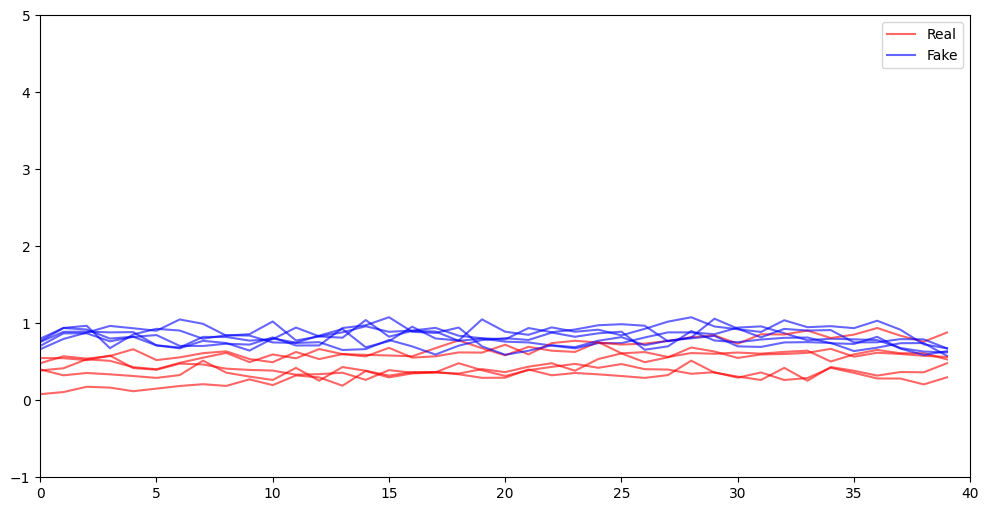

4/4 [==============================] - 0s 3ms/step
480 epoch, Recognizing real data: 0.9300000071525574 , Recognizing fake data: 0.0


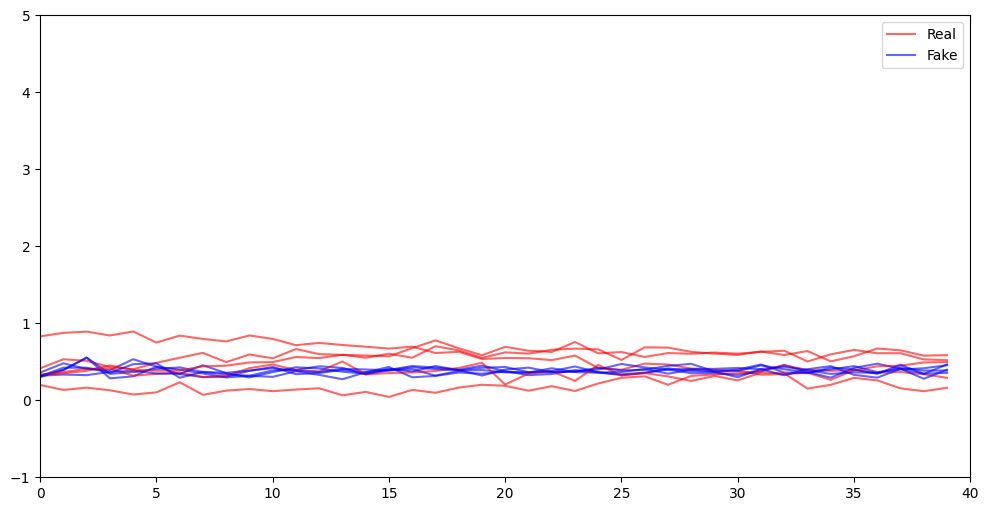

4/4 [==============================] - 0s 3ms/step
490 epoch, Recognizing real data: 0.8500000238418579 , Recognizing fake data: 0.05999999865889549


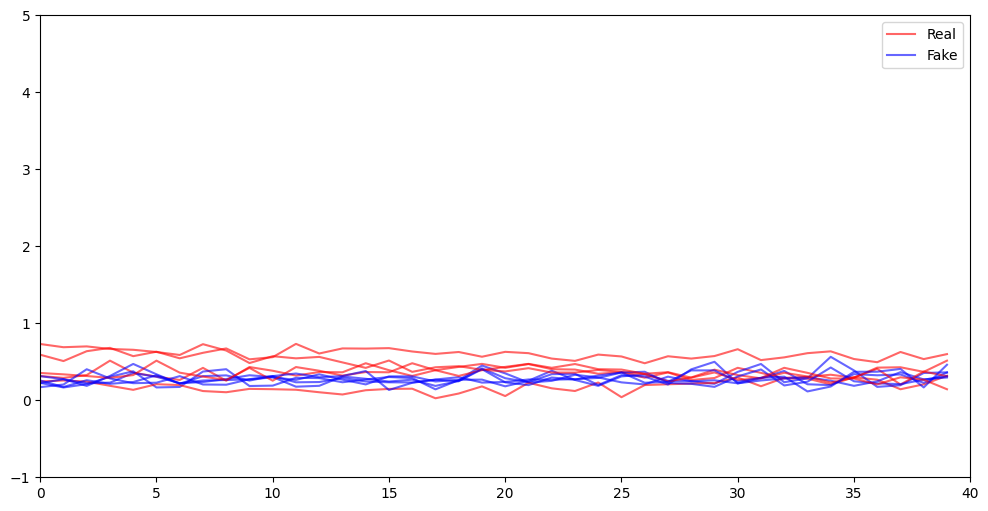

4/4 [==============================] - 0s 4ms/step
500 epoch, Recognizing real data: 0.0 , Recognizing fake data: 1.0


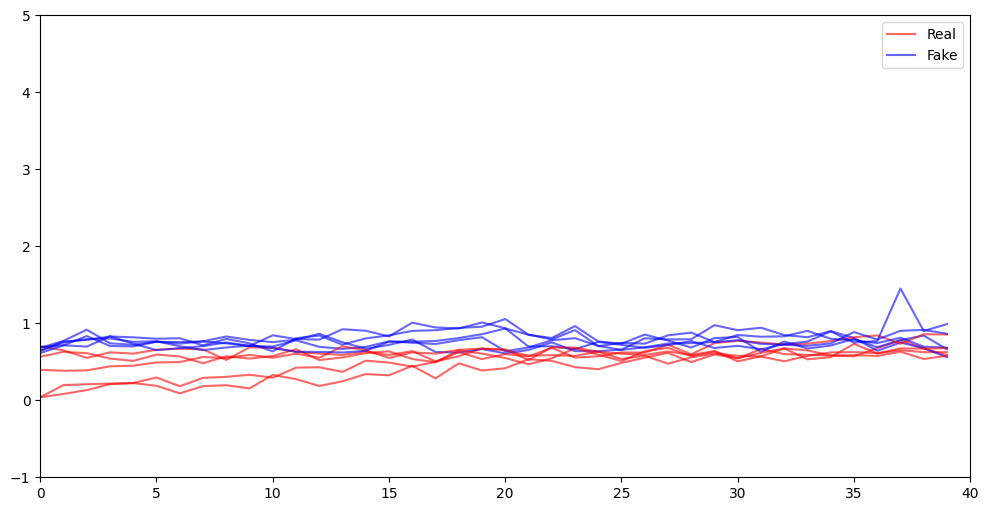

4/4 [==============================] - 0s 4ms/step
510 epoch, Recognizing real data: 0.36000001430511475 , Recognizing fake data: 0.28999999165534973


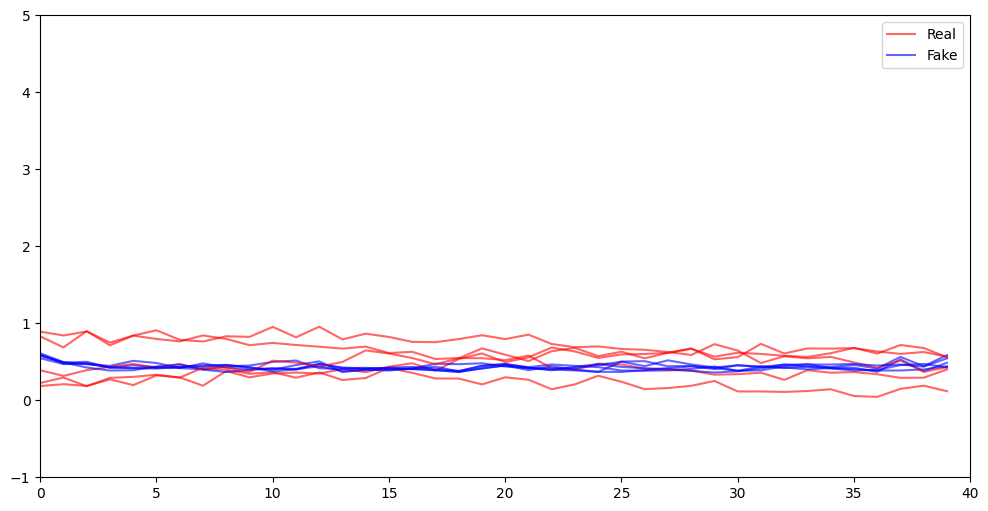

4/4 [==============================] - 0s 4ms/step
520 epoch, Recognizing real data: 0.07000000029802322 , Recognizing fake data: 1.0


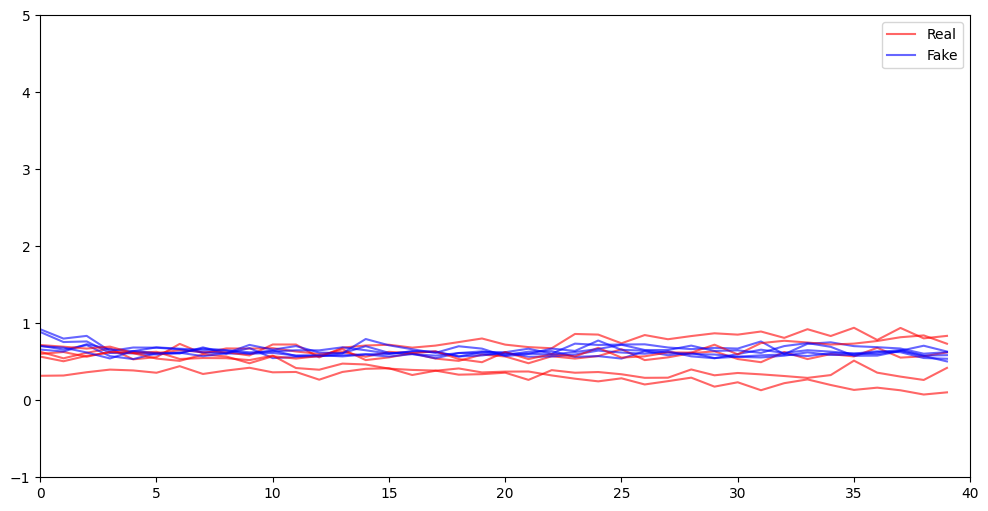

4/4 [==============================] - 0s 4ms/step
530 epoch, Recognizing real data: 0.4300000071525574 , Recognizing fake data: 1.0


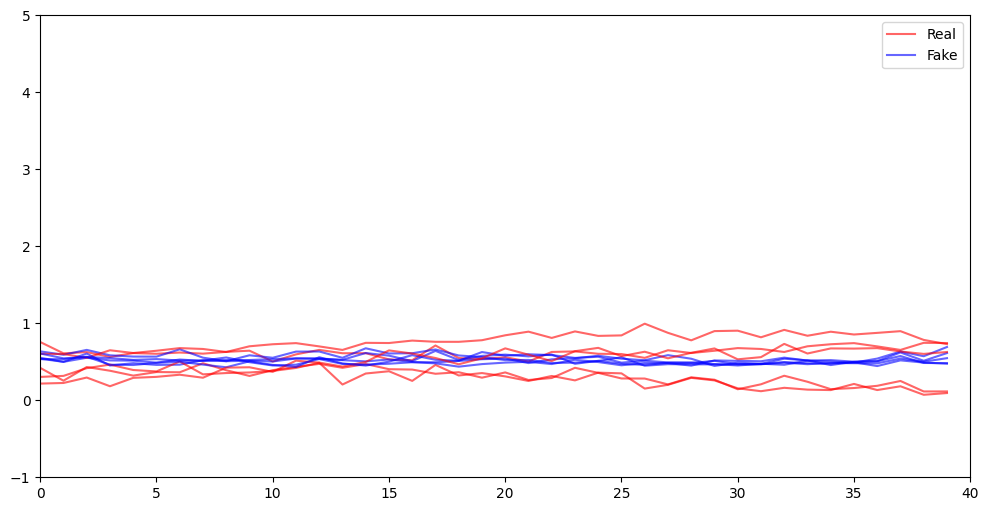

4/4 [==============================] - 0s 4ms/step
540 epoch, Recognizing real data: 0.8700000047683716 , Recognizing fake data: 0.25999999046325684


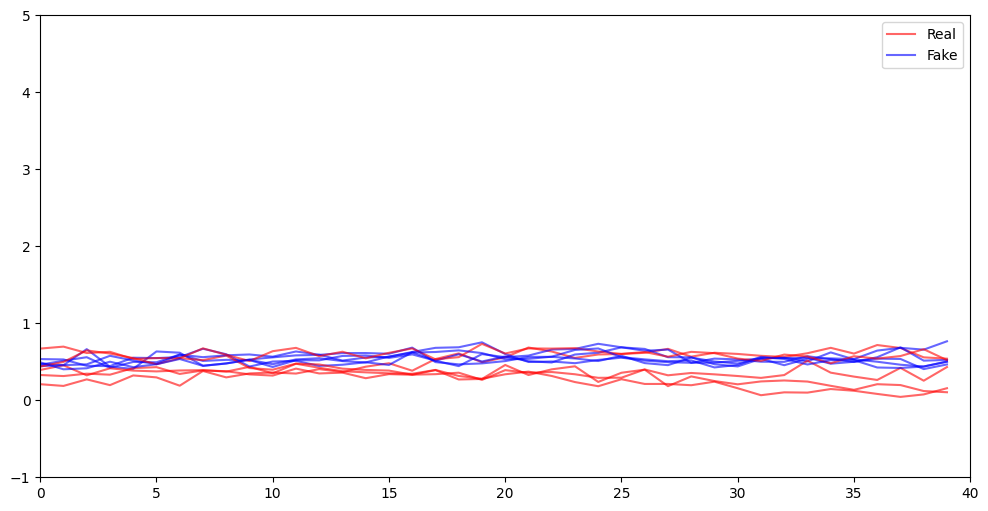

4/4 [==============================] - 0s 3ms/step
550 epoch, Recognizing real data: 0.3199999928474426 , Recognizing fake data: 1.0


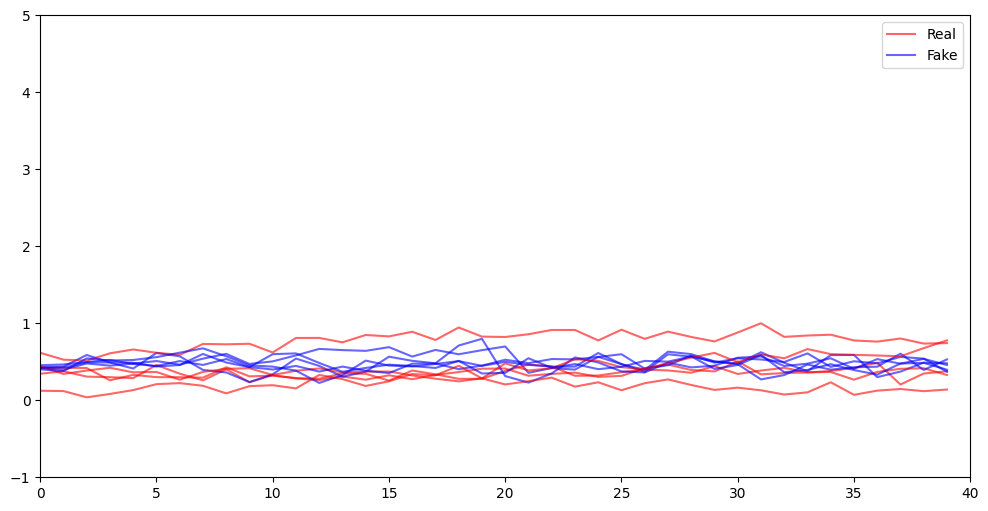

4/4 [==============================] - 0s 4ms/step
560 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.33000001311302185


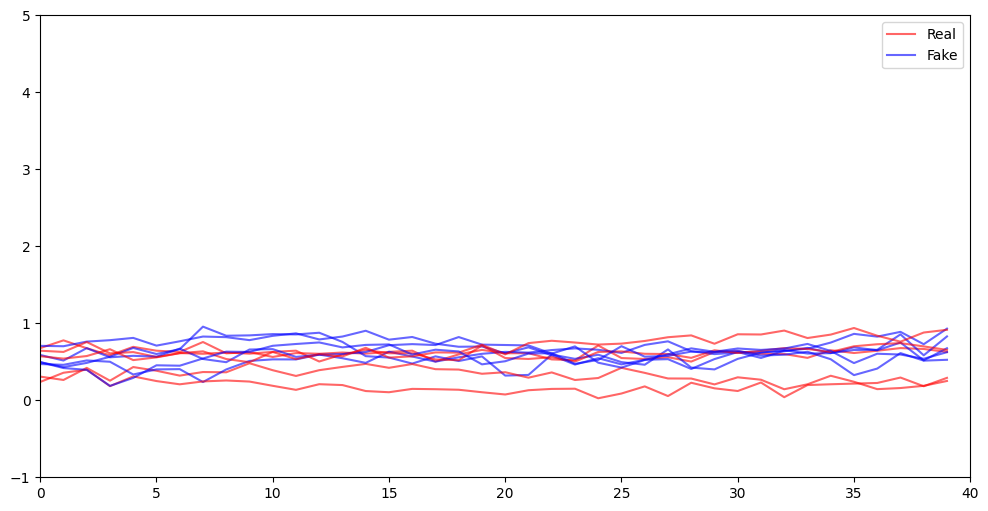

4/4 [==============================] - 0s 4ms/step
570 epoch, Recognizing real data: 0.6299999952316284 , Recognizing fake data: 0.949999988079071


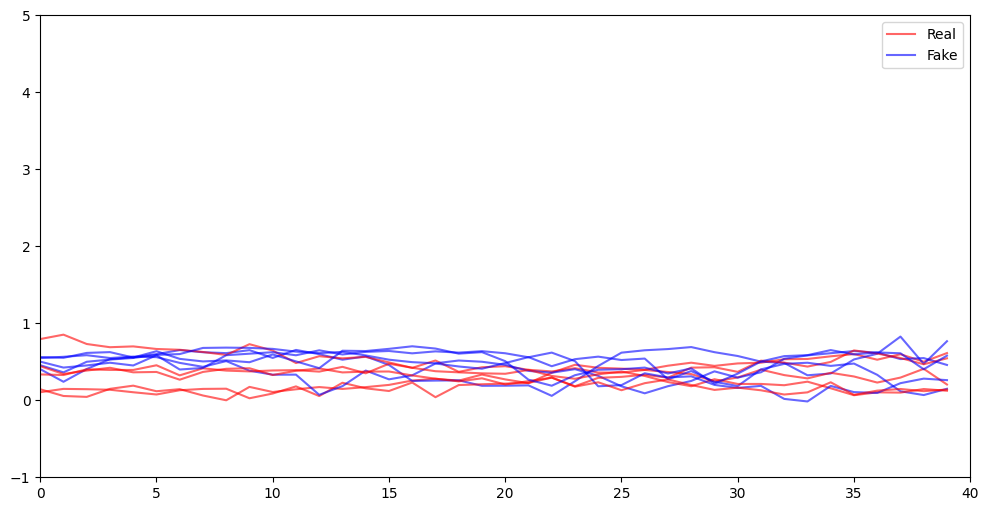

4/4 [==============================] - 0s 5ms/step
580 epoch, Recognizing real data: 0.9800000190734863 , Recognizing fake data: 0.09000000357627869


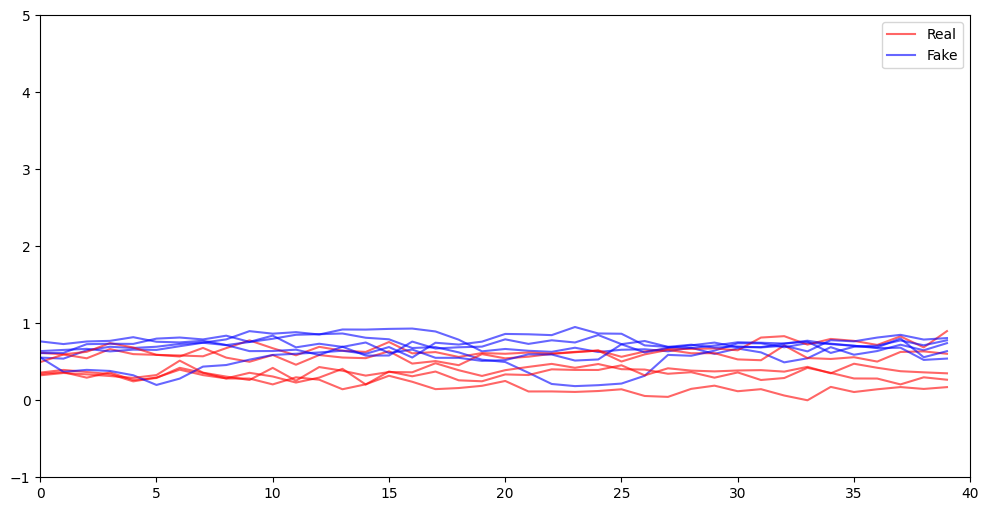

4/4 [==============================] - 0s 4ms/step
590 epoch, Recognizing real data: 0.9300000071525574 , Recognizing fake data: 0.0


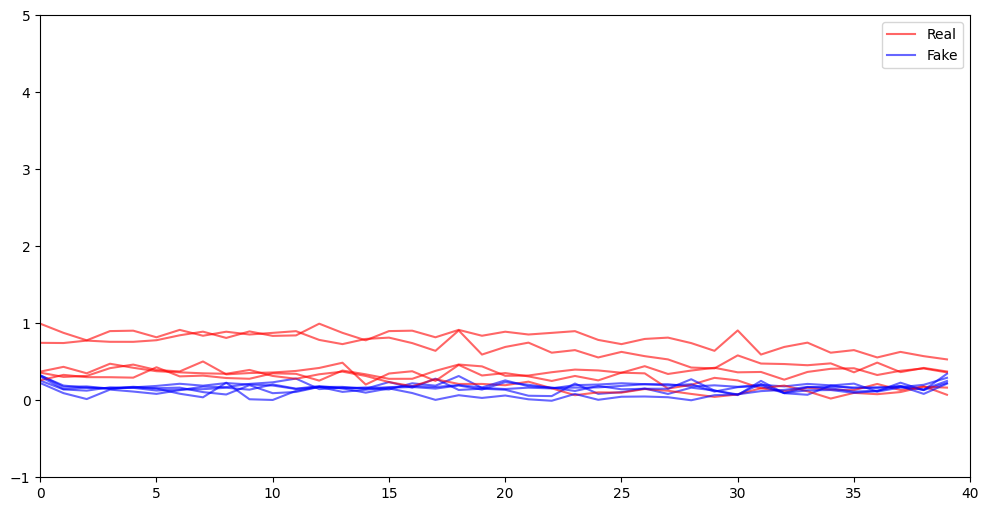

4/4 [==============================] - 0s 4ms/step
600 epoch, Recognizing real data: 0.8299999833106995 , Recognizing fake data: 0.9900000095367432


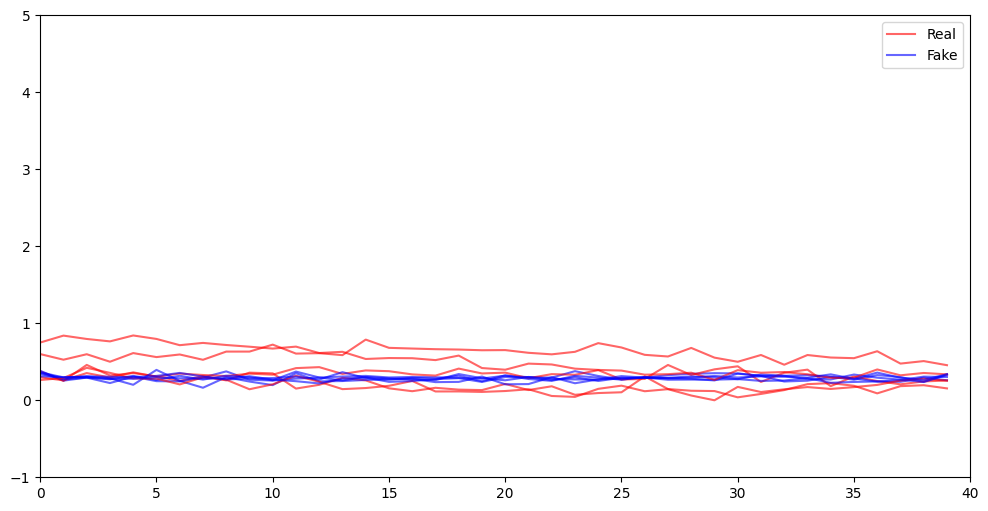

4/4 [==============================] - 0s 4ms/step
610 epoch, Recognizing real data: 0.009999999776482582 , Recognizing fake data: 1.0


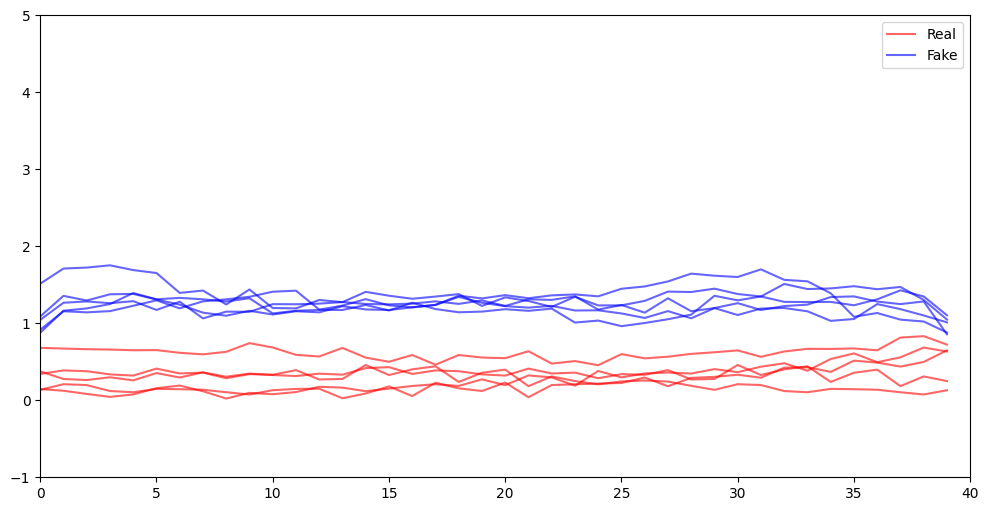

4/4 [==============================] - 0s 4ms/step
620 epoch, Recognizing real data: 0.4300000071525574 , Recognizing fake data: 0.44999998807907104


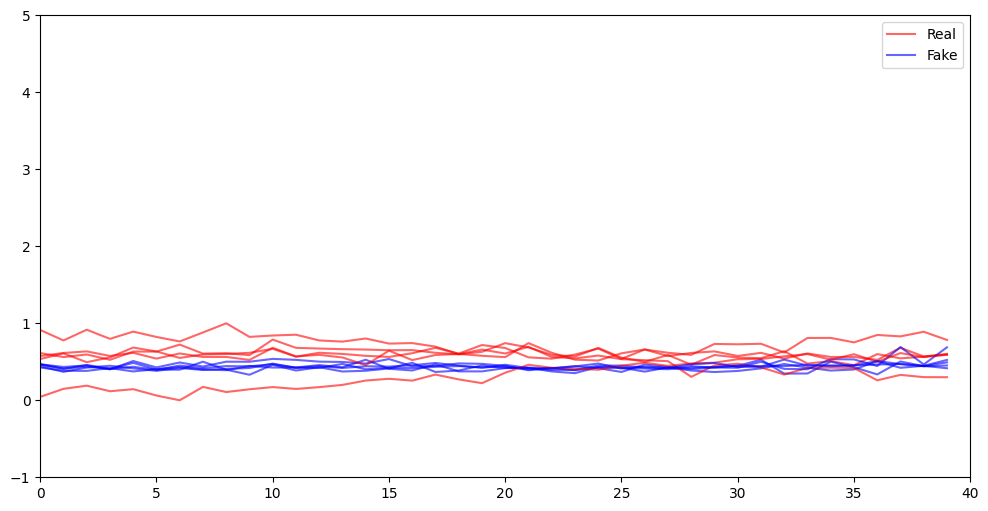

4/4 [==============================] - 0s 3ms/step
630 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


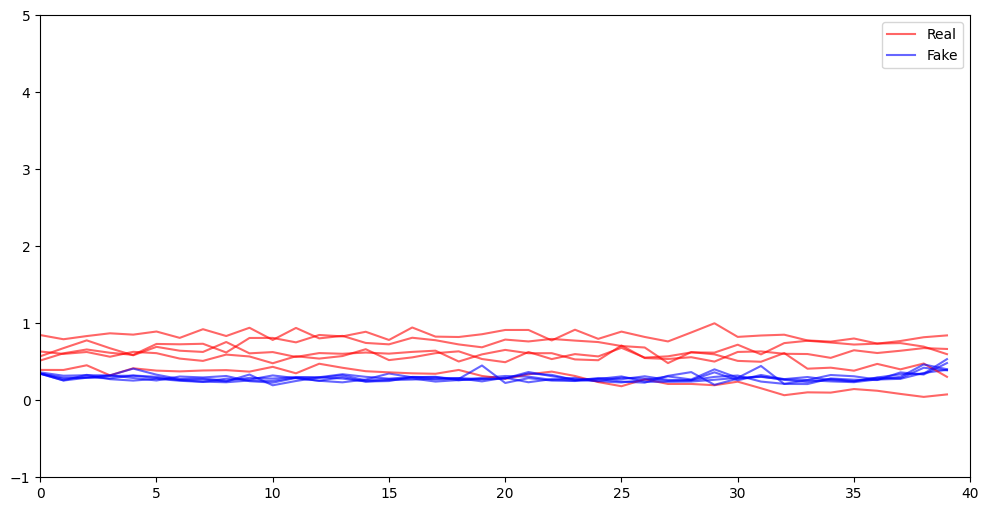

4/4 [==============================] - 0s 5ms/step
640 epoch, Recognizing real data: 0.7300000190734863 , Recognizing fake data: 1.0


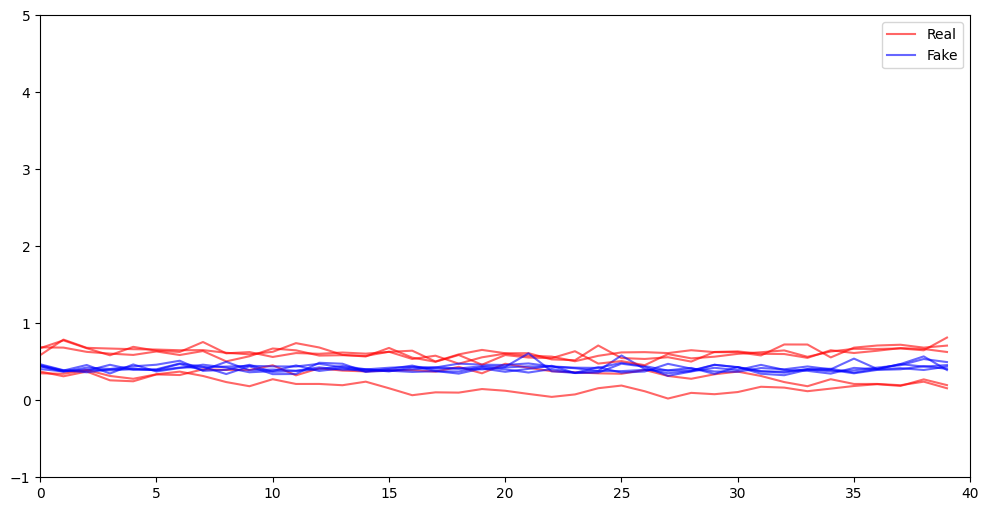

4/4 [==============================] - 0s 4ms/step
650 epoch, Recognizing real data: 0.14000000059604645 , Recognizing fake data: 1.0


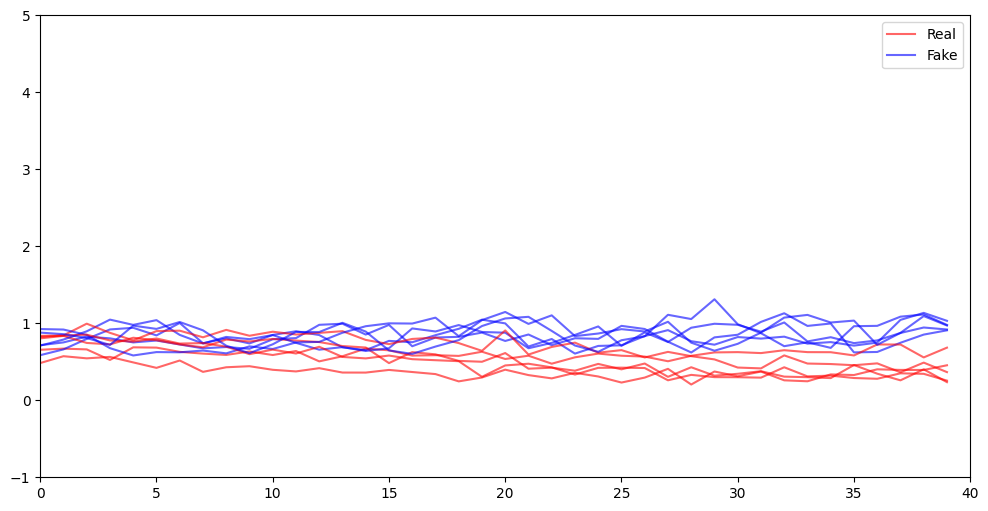

4/4 [==============================] - 0s 4ms/step
660 epoch, Recognizing real data: 0.5699999928474426 , Recognizing fake data: 1.0


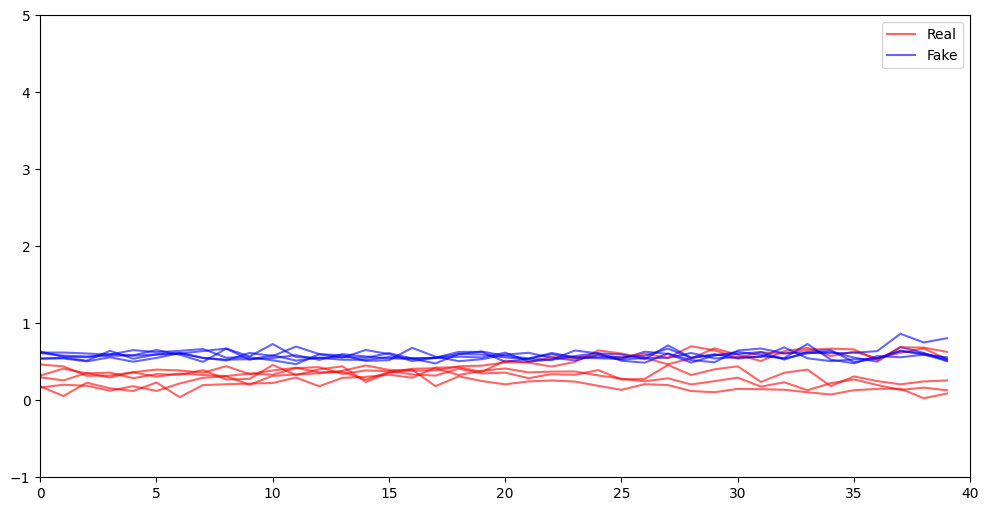

4/4 [==============================] - 0s 3ms/step
670 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


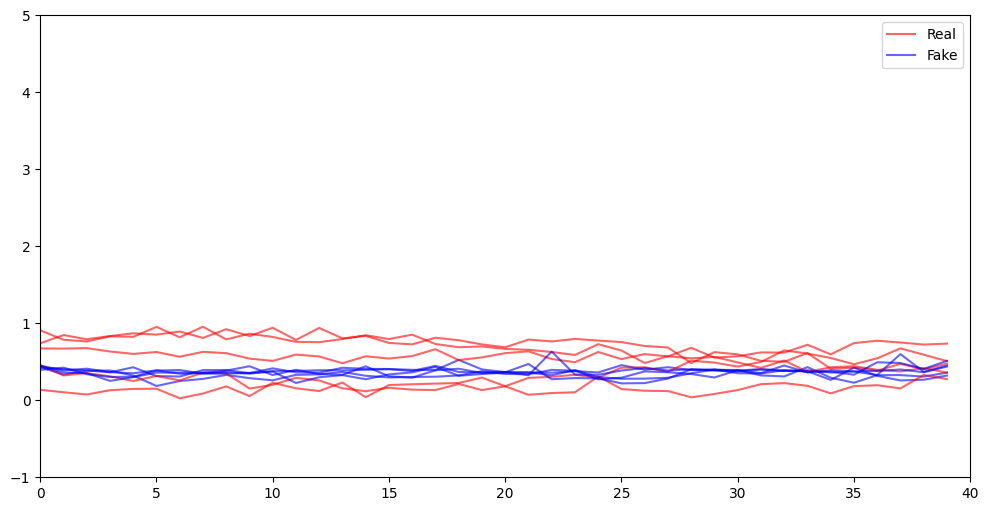

4/4 [==============================] - 0s 5ms/step
680 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


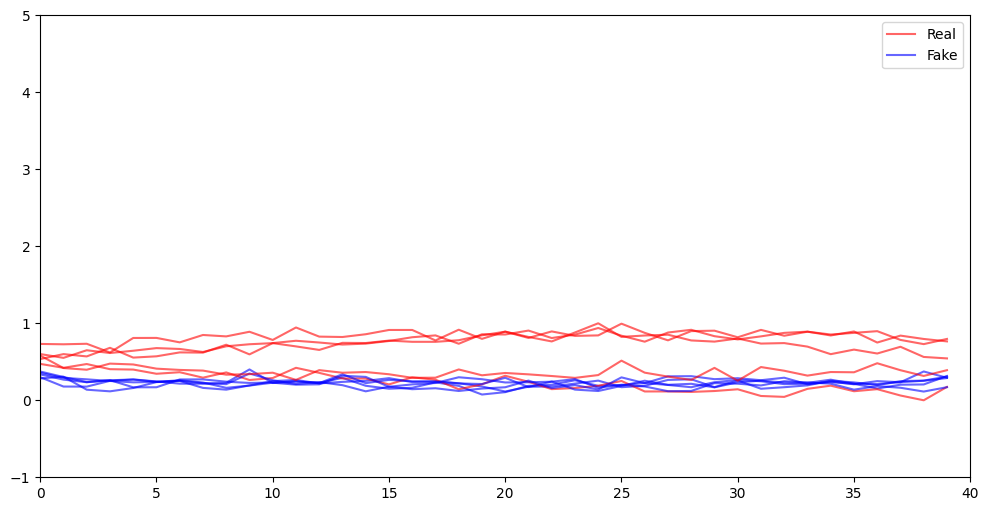

4/4 [==============================] - 0s 4ms/step
690 epoch, Recognizing real data: 0.4300000071525574 , Recognizing fake data: 0.949999988079071


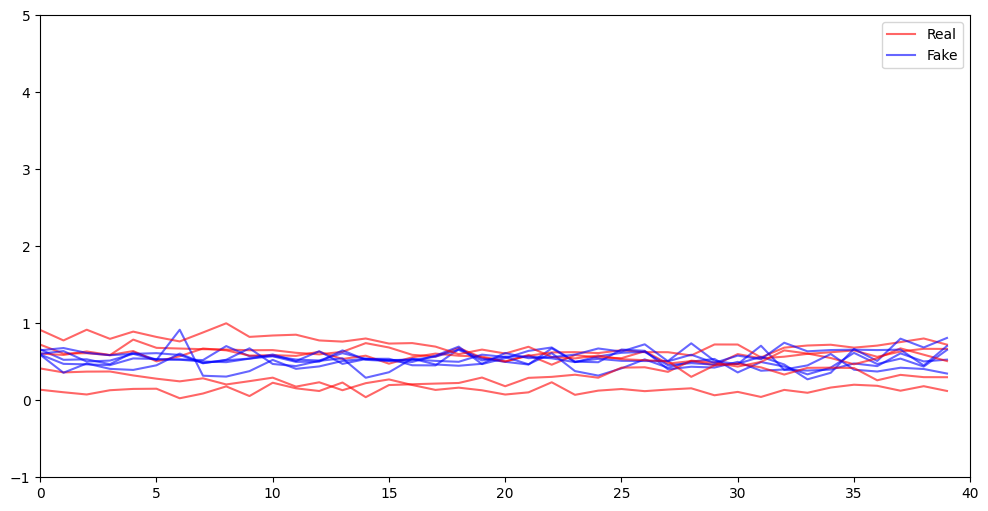

4/4 [==============================] - 0s 4ms/step
700 epoch, Recognizing real data: 0.03999999910593033 , Recognizing fake data: 1.0


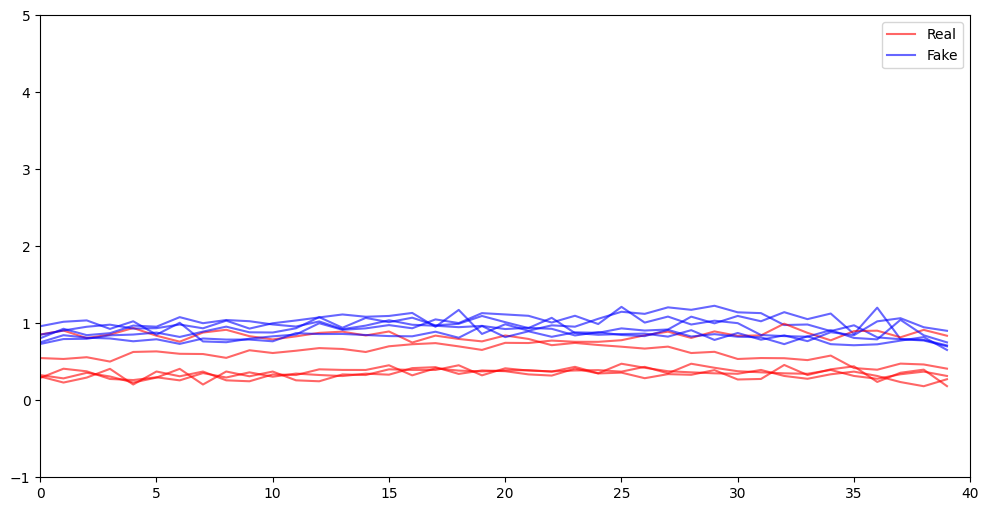

4/4 [==============================] - 0s 7ms/step
710 epoch, Recognizing real data: 0.49000000953674316 , Recognizing fake data: 1.0


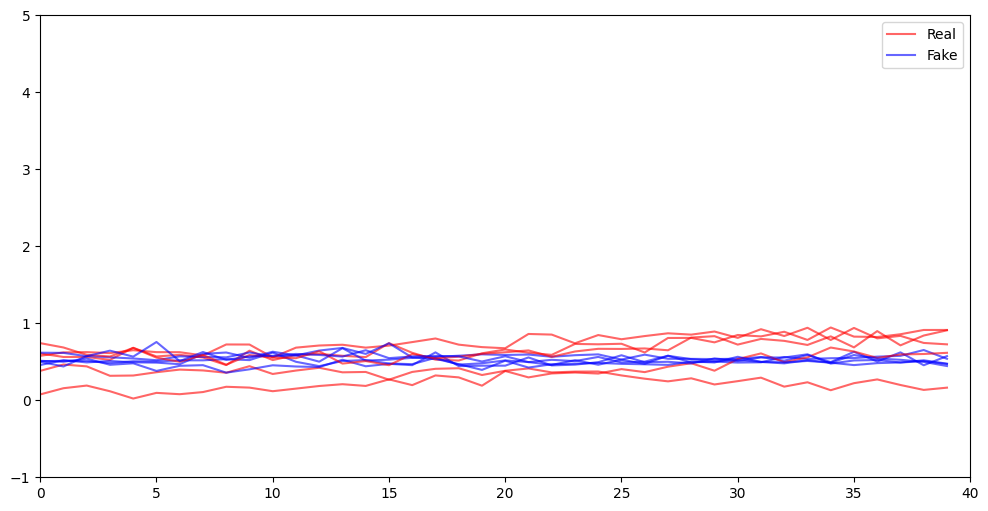

4/4 [==============================] - 0s 5ms/step
720 epoch, Recognizing real data: 0.6499999761581421 , Recognizing fake data: 0.9900000095367432


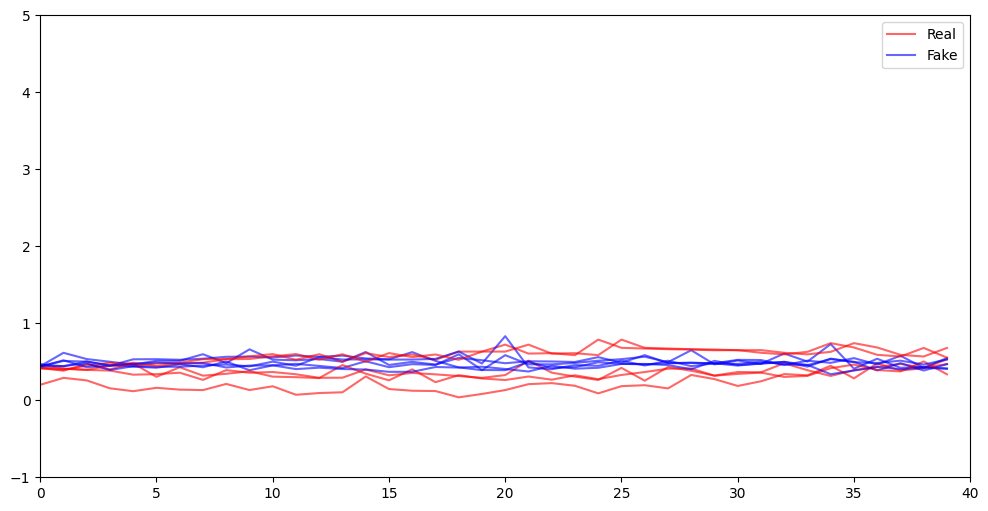

4/4 [==============================] - 0s 3ms/step
730 epoch, Recognizing real data: 0.5600000023841858 , Recognizing fake data: 1.0


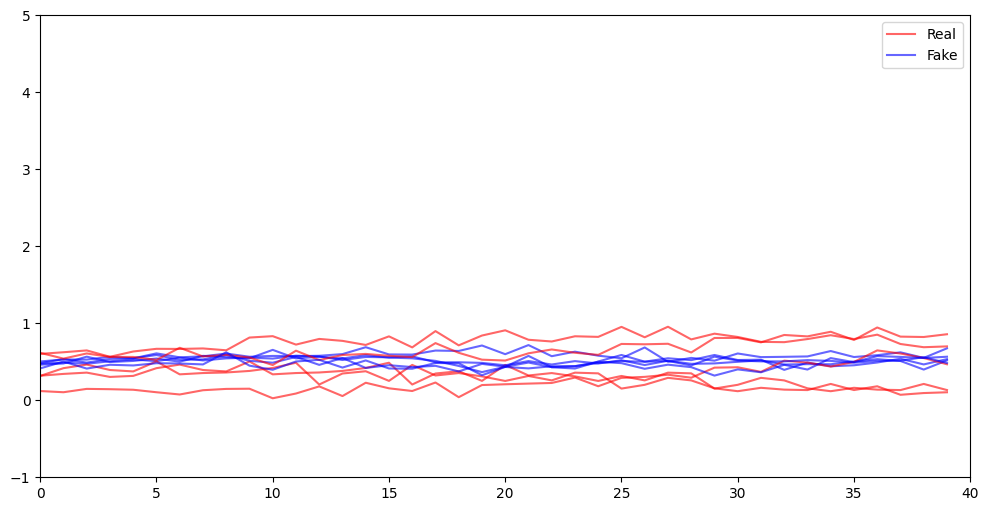

4/4 [==============================] - 0s 4ms/step
740 epoch, Recognizing real data: 0.2199999988079071 , Recognizing fake data: 1.0


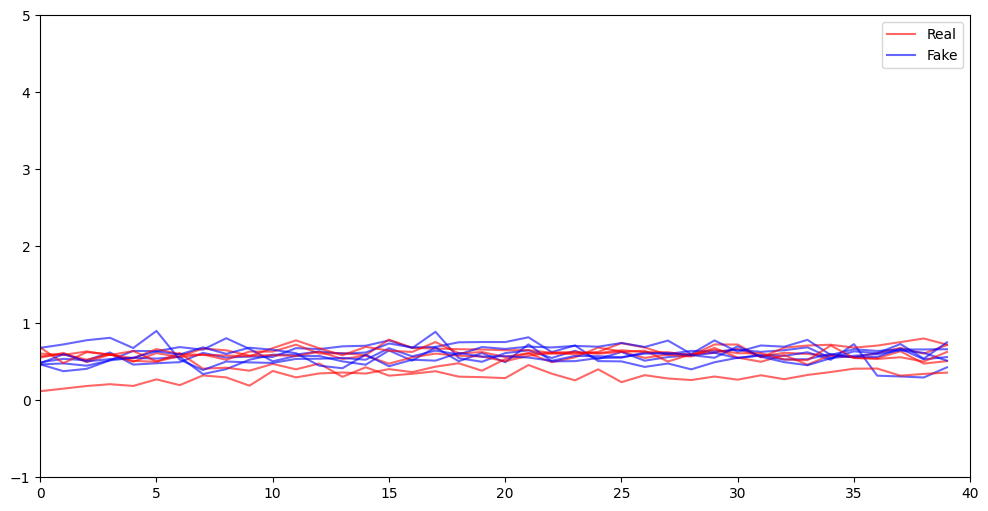

4/4 [==============================] - 0s 3ms/step
750 epoch, Recognizing real data: 0.550000011920929 , Recognizing fake data: 0.8799999952316284


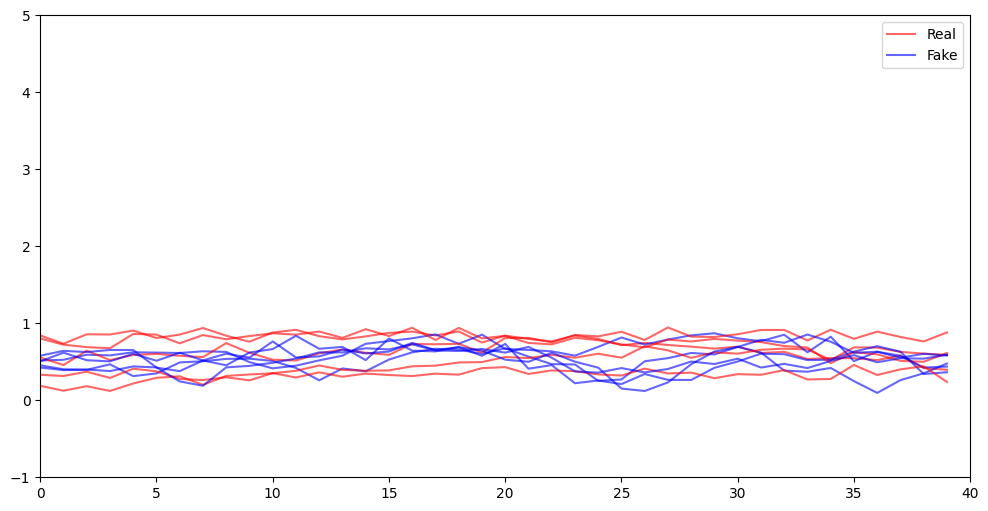

4/4 [==============================] - 0s 4ms/step
760 epoch, Recognizing real data: 0.9800000190734863 , Recognizing fake data: 0.6499999761581421


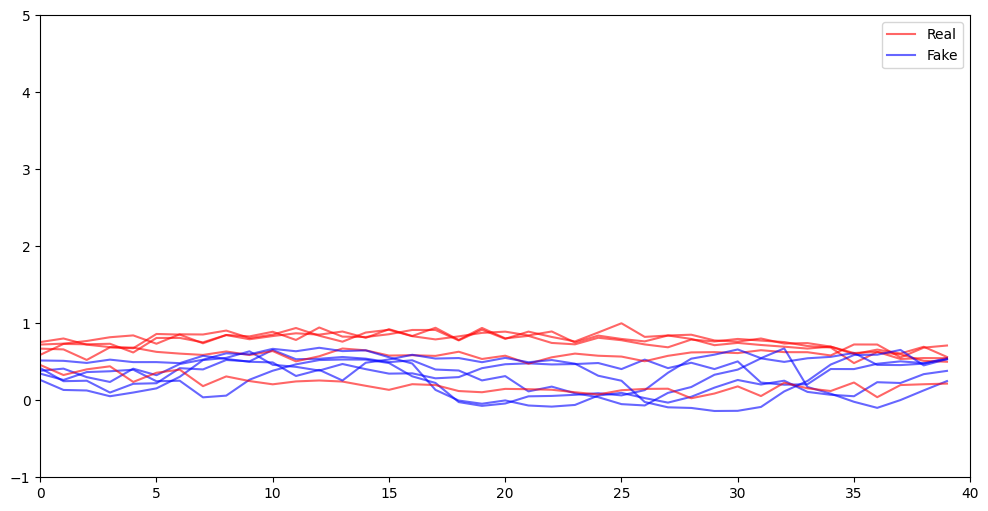

4/4 [==============================] - 0s 5ms/step
770 epoch, Recognizing real data: 0.25 , Recognizing fake data: 1.0


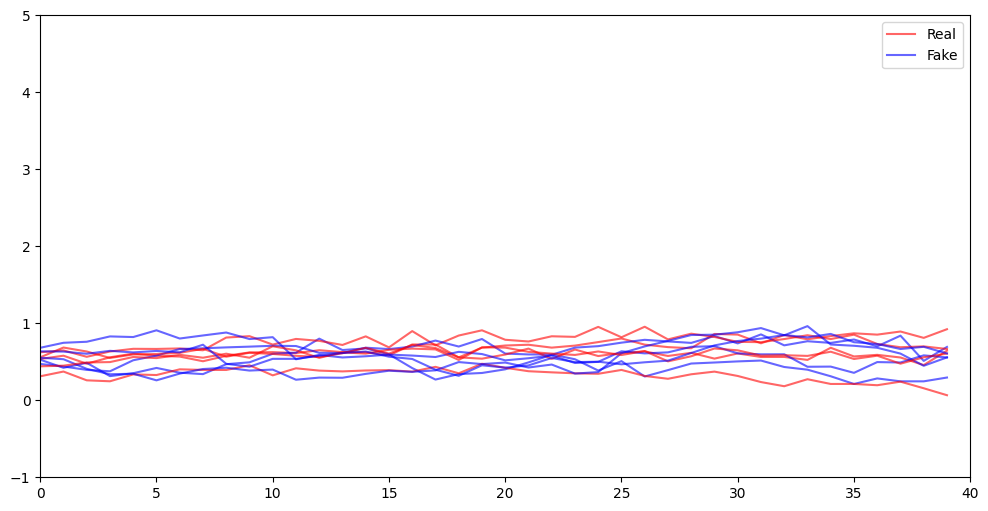

4/4 [==============================] - 0s 3ms/step
780 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


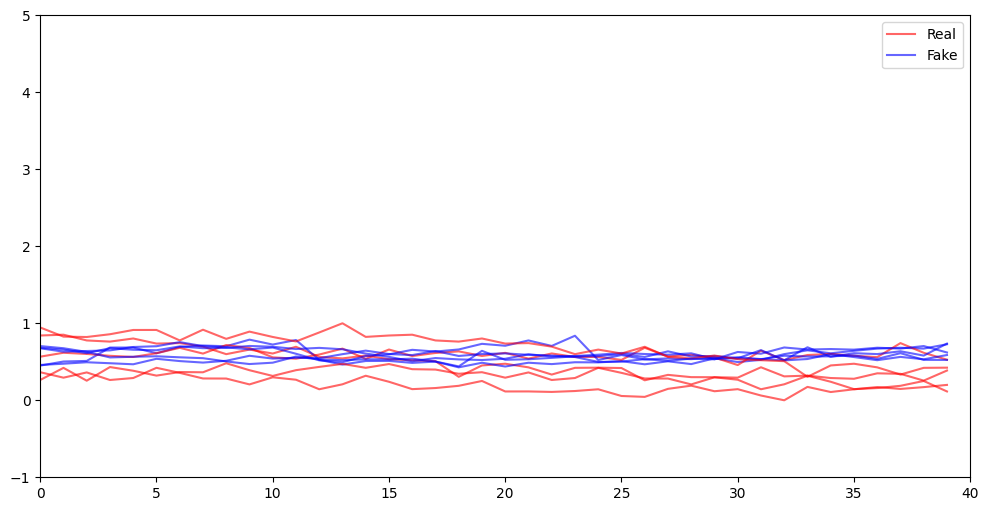

4/4 [==============================] - 0s 5ms/step
790 epoch, Recognizing real data: 0.7400000095367432 , Recognizing fake data: 0.949999988079071


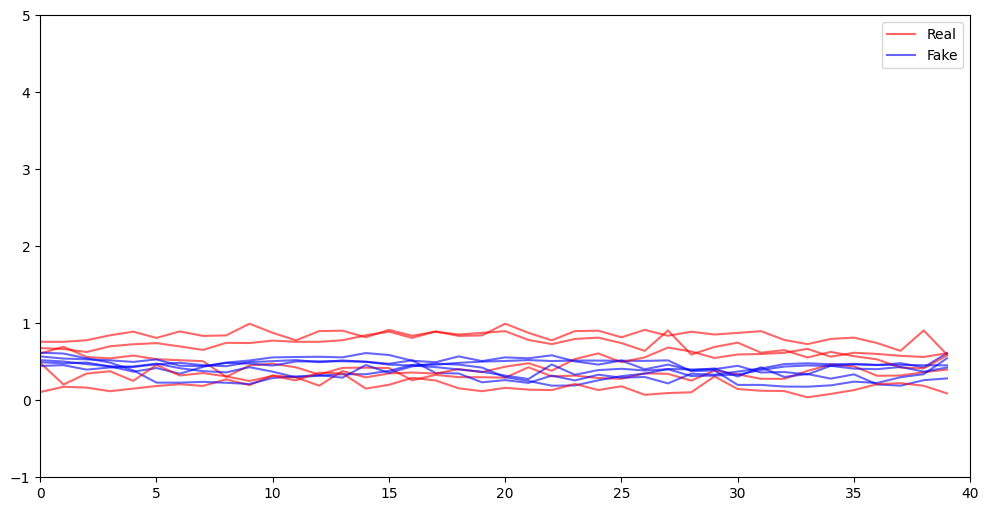

4/4 [==============================] - 0s 4ms/step
800 epoch, Recognizing real data: 0.7799999713897705 , Recognizing fake data: 0.9399999976158142


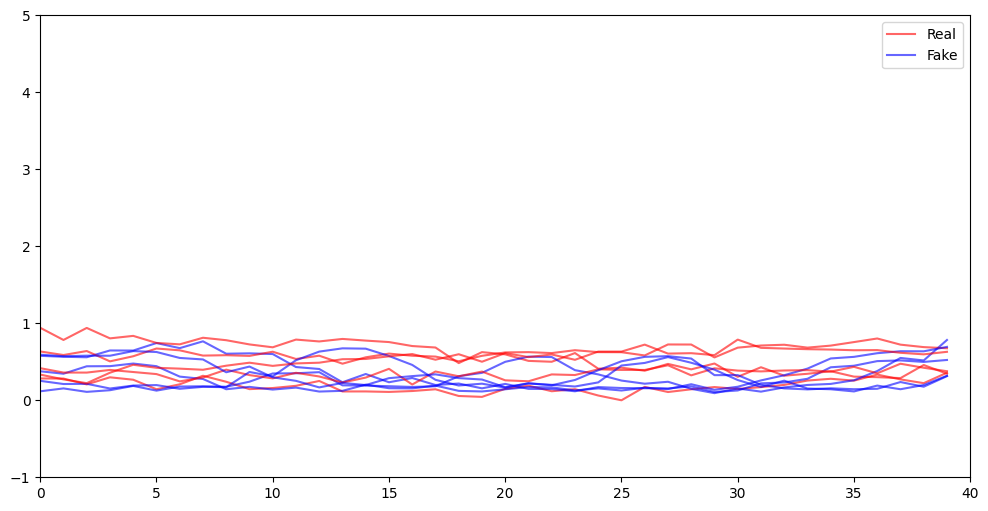

4/4 [==============================] - 0s 4ms/step
810 epoch, Recognizing real data: 0.7900000214576721 , Recognizing fake data: 1.0


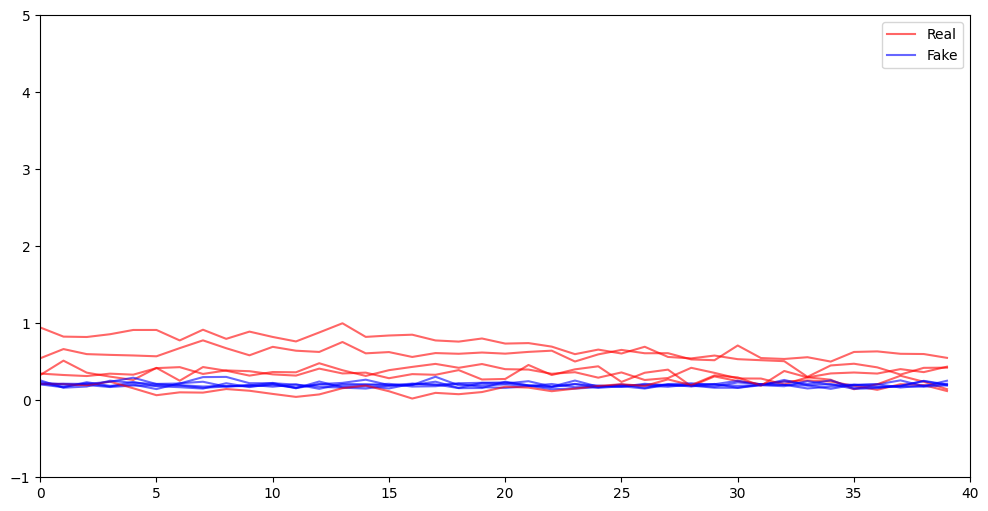

4/4 [==============================] - 0s 4ms/step
820 epoch, Recognizing real data: 0.0 , Recognizing fake data: 1.0


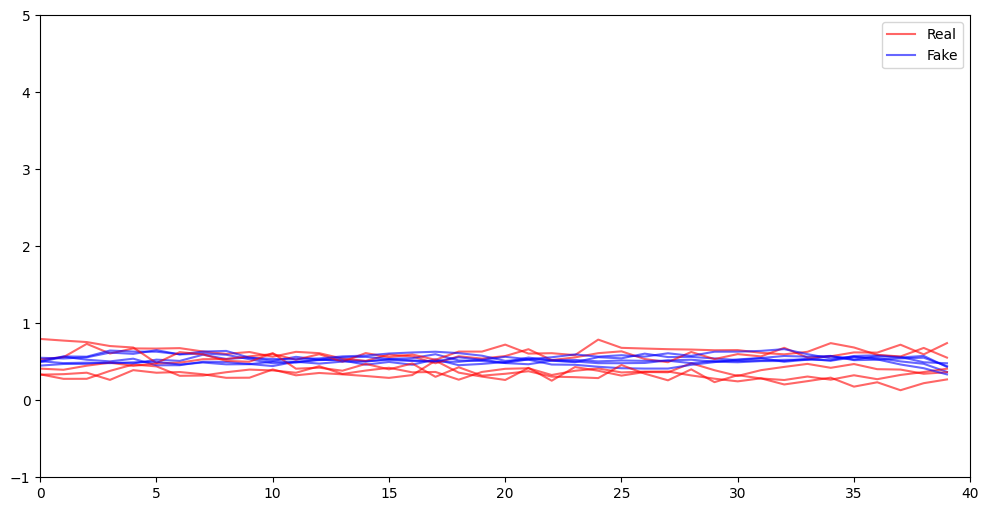

4/4 [==============================] - 0s 4ms/step
830 epoch, Recognizing real data: 0.47999998927116394 , Recognizing fake data: 1.0


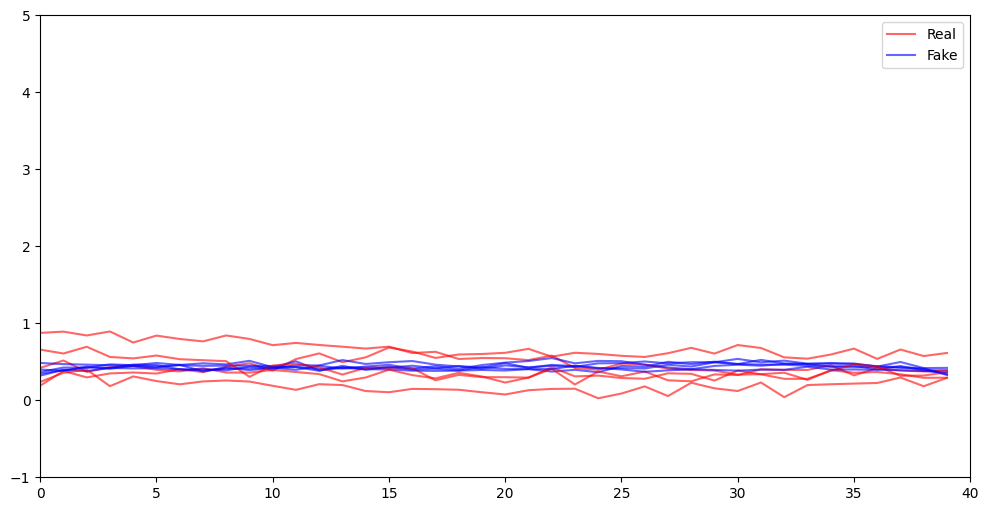

4/4 [==============================] - 0s 5ms/step
840 epoch, Recognizing real data: 0.8199999928474426 , Recognizing fake data: 0.9100000262260437


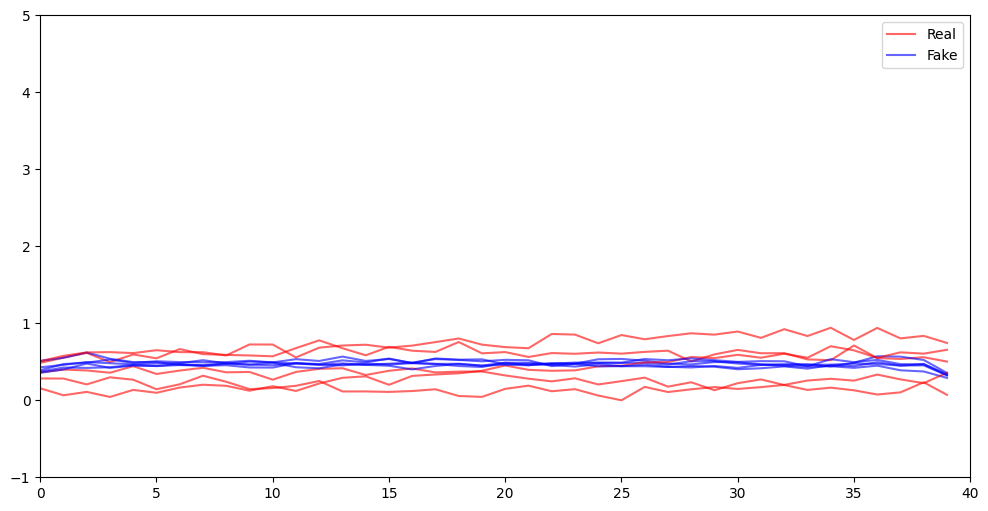

4/4 [==============================] - 0s 3ms/step
850 epoch, Recognizing real data: 0.6899999976158142 , Recognizing fake data: 0.7099999785423279


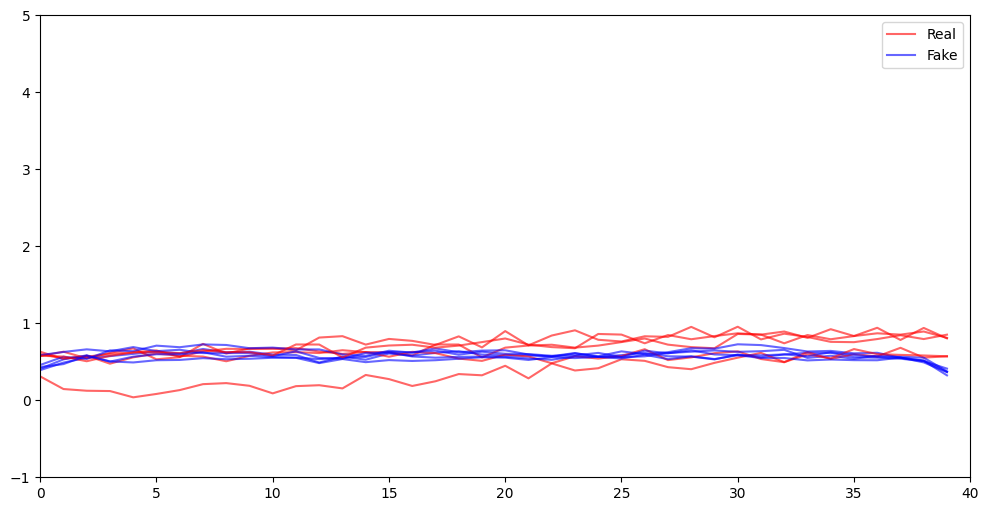

4/4 [==============================] - 0s 4ms/step
860 epoch, Recognizing real data: 0.5199999809265137 , Recognizing fake data: 1.0


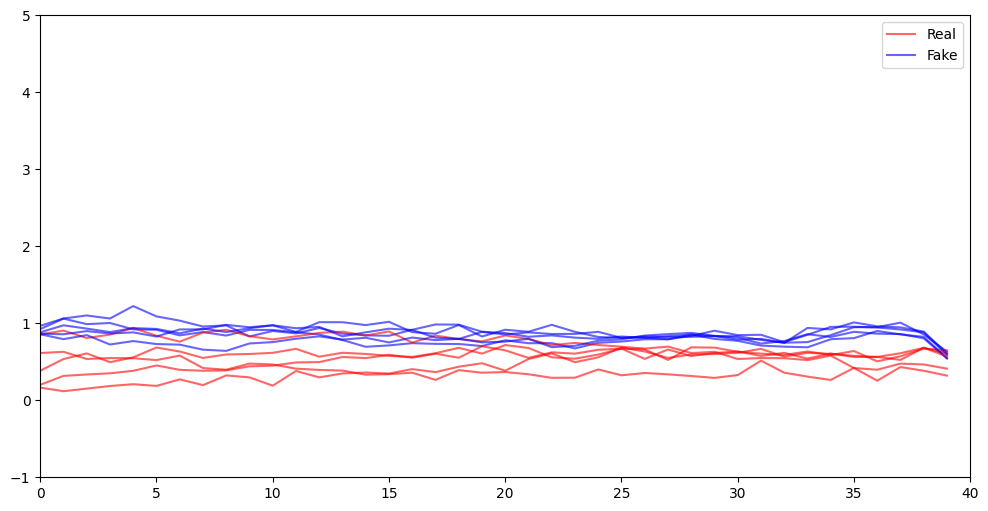

4/4 [==============================] - 0s 4ms/step
870 epoch, Recognizing real data: 0.27000001072883606 , Recognizing fake data: 0.5099999904632568


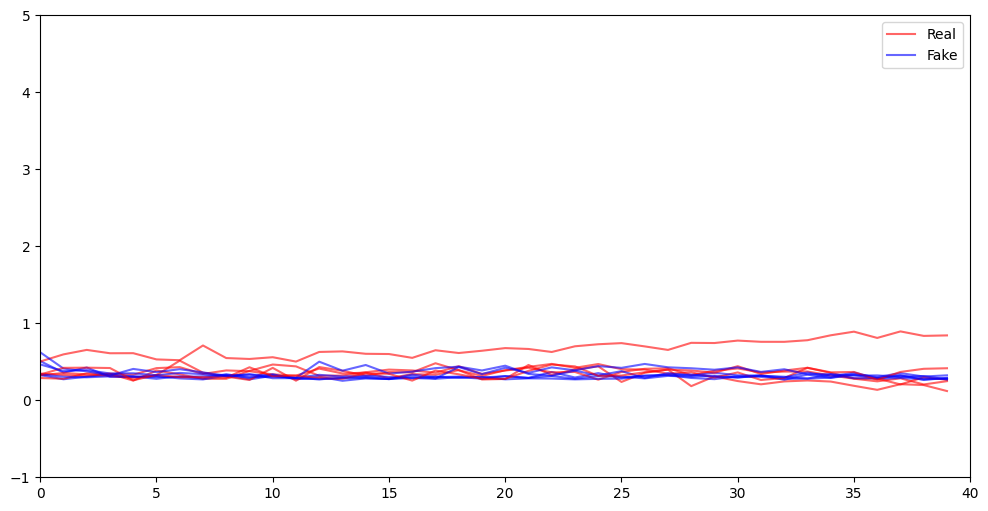

4/4 [==============================] - 0s 4ms/step
880 epoch, Recognizing real data: 0.5600000023841858 , Recognizing fake data: 1.0


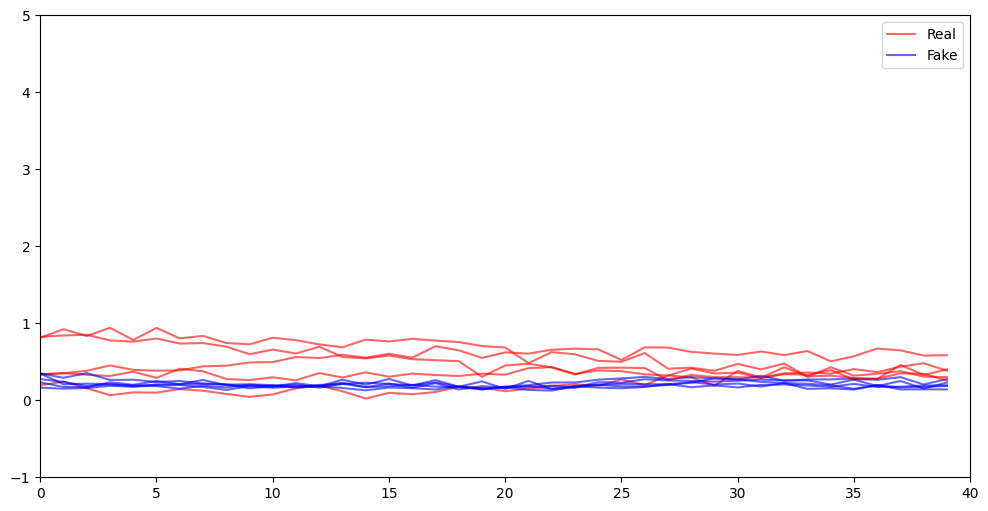

4/4 [==============================] - 0s 3ms/step
890 epoch, Recognizing real data: 0.6399999856948853 , Recognizing fake data: 0.6000000238418579


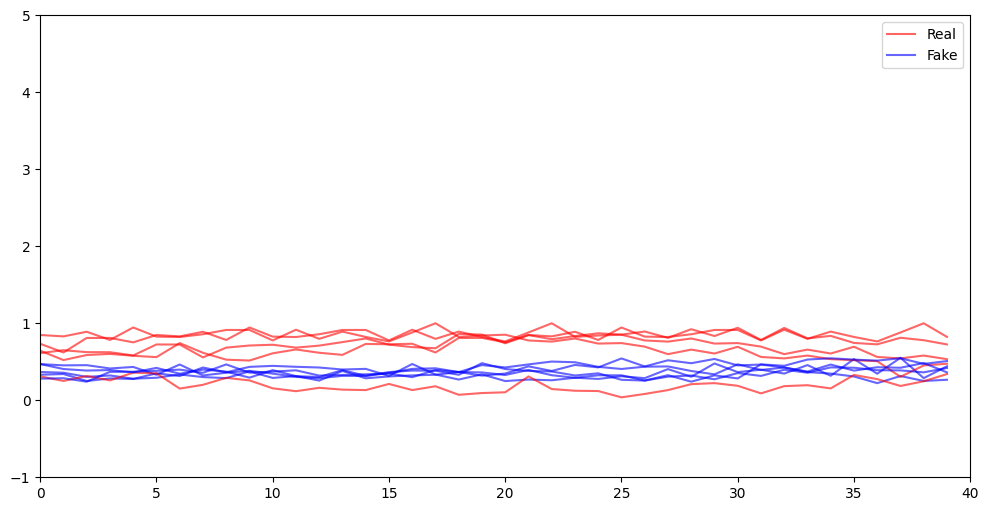

4/4 [==============================] - 0s 5ms/step
900 epoch, Recognizing real data: 0.0 , Recognizing fake data: 1.0


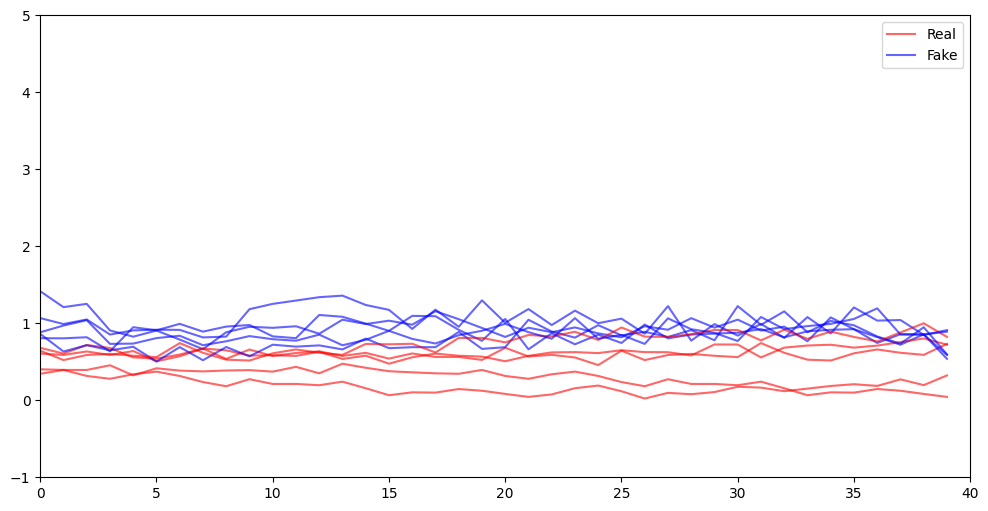

4/4 [==============================] - 0s 3ms/step
910 epoch, Recognizing real data: 0.6800000071525574 , Recognizing fake data: 0.009999999776482582


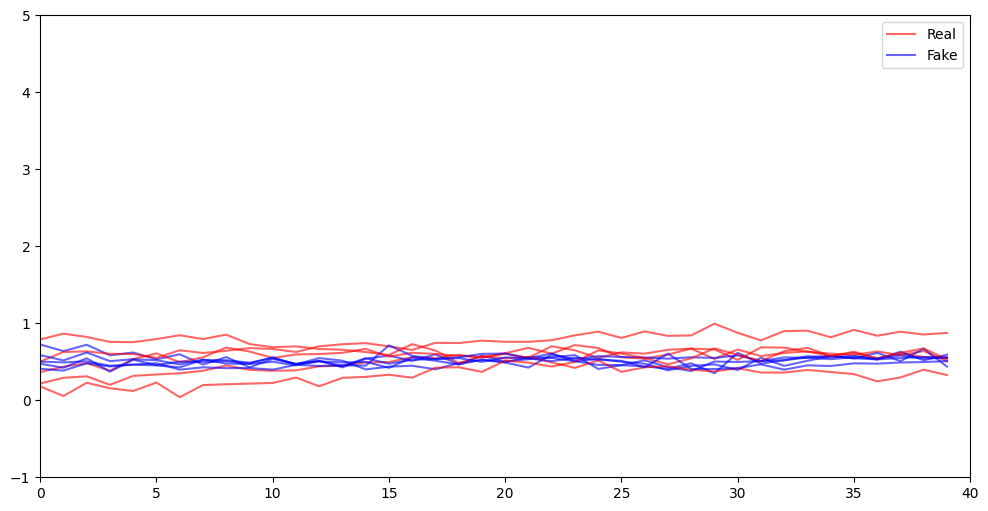

4/4 [==============================] - 0s 4ms/step
920 epoch, Recognizing real data: 0.7400000095367432 , Recognizing fake data: 0.009999999776482582


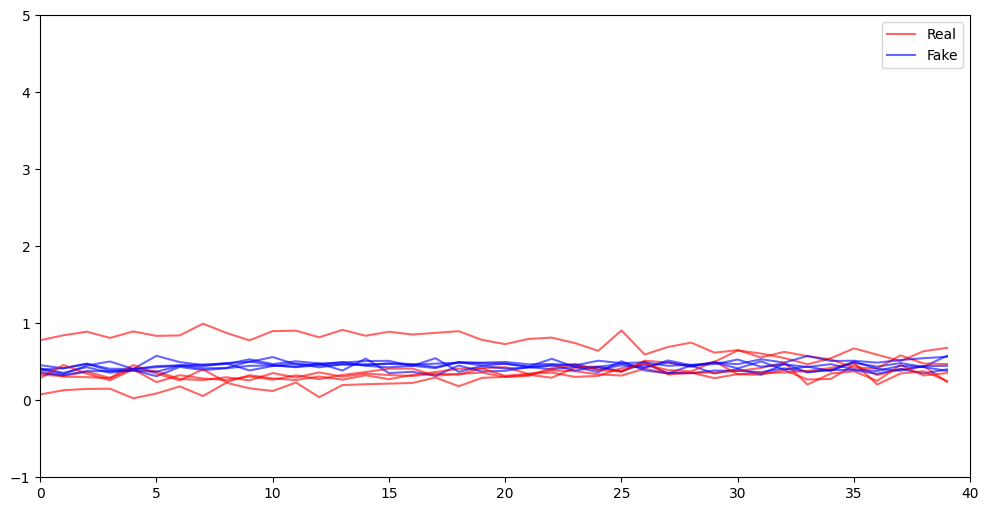

4/4 [==============================] - 0s 4ms/step
930 epoch, Recognizing real data: 0.8299999833106995 , Recognizing fake data: 0.25


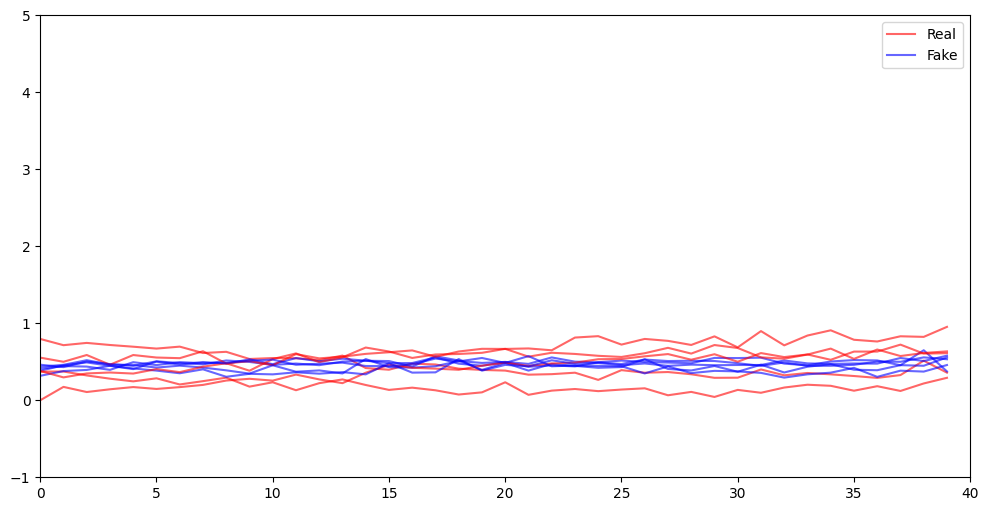

4/4 [==============================] - 0s 4ms/step
940 epoch, Recognizing real data: 0.5699999928474426 , Recognizing fake data: 0.8500000238418579


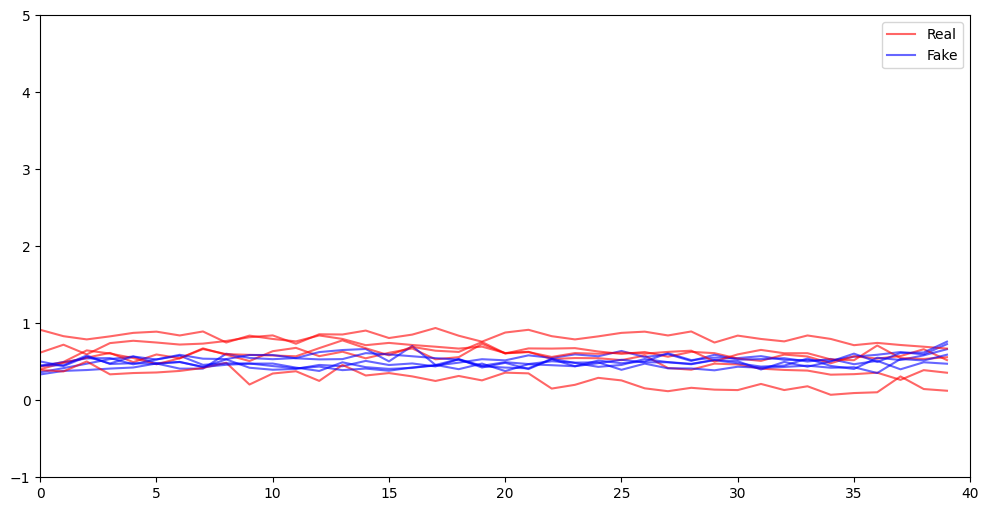

4/4 [==============================] - 0s 4ms/step
950 epoch, Recognizing real data: 0.25 , Recognizing fake data: 1.0


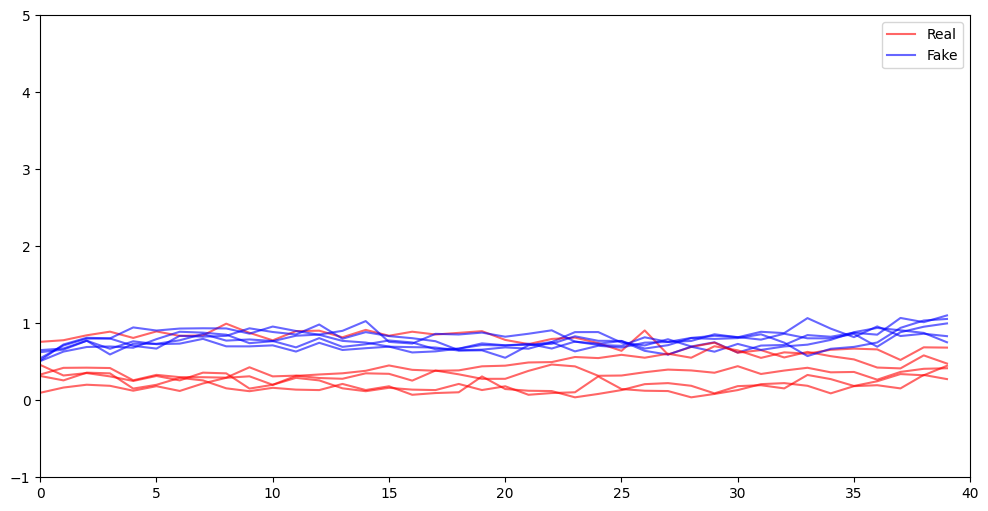

4/4 [==============================] - 0s 4ms/step
960 epoch, Recognizing real data: 0.4000000059604645 , Recognizing fake data: 0.800000011920929


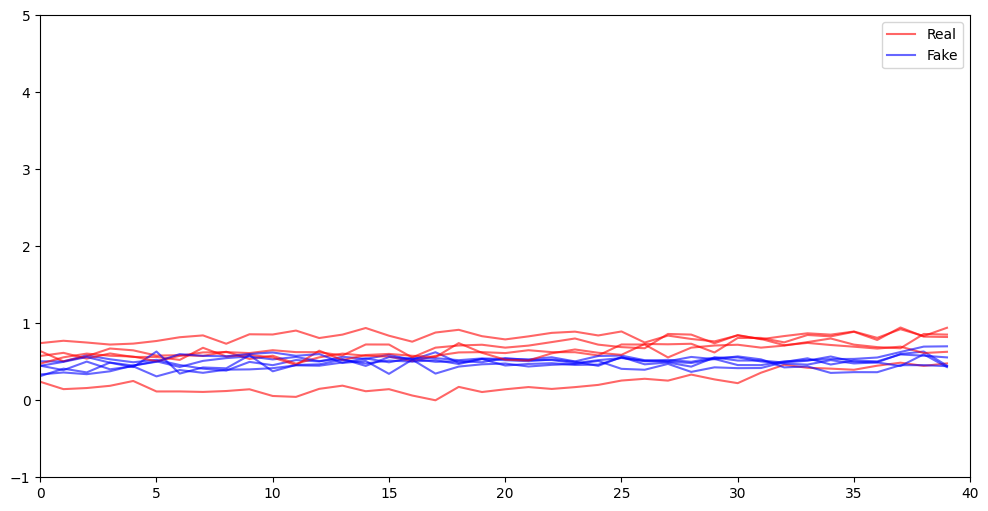

4/4 [==============================] - 0s 5ms/step
970 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.0


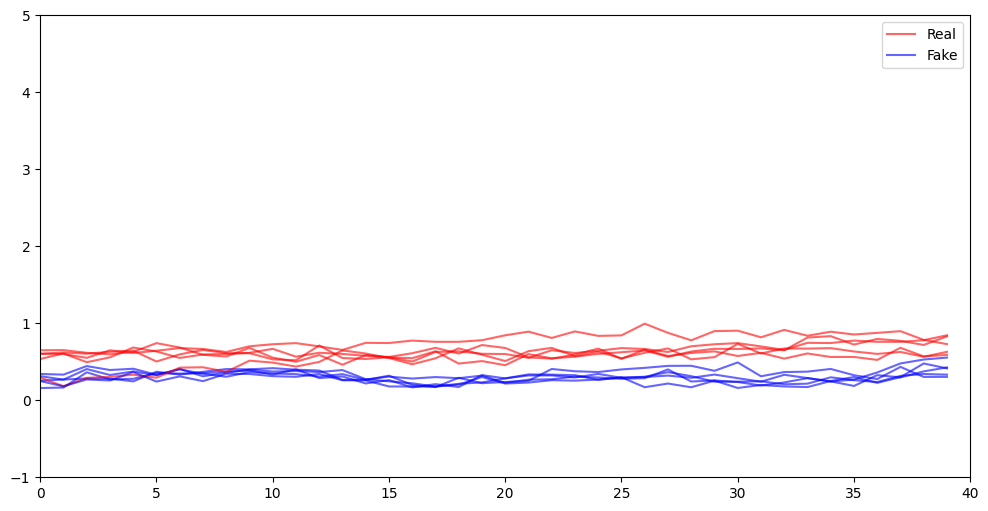

4/4 [==============================] - 0s 3ms/step
980 epoch, Recognizing real data: 1.0 , Recognizing fake data: 0.33000001311302185


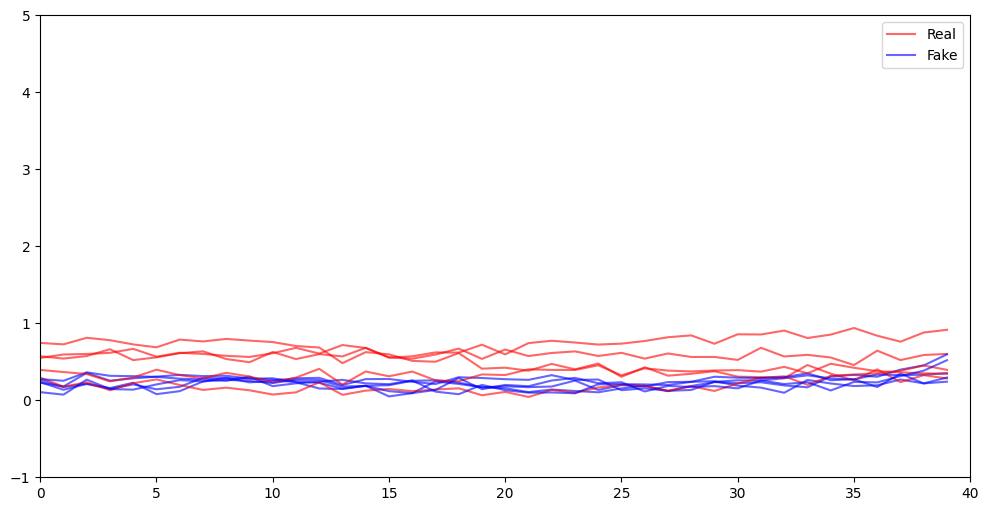

4/4 [==============================] - 0s 4ms/step
990 epoch, Recognizing real data: 0.4000000059604645 , Recognizing fake data: 0.8799999952316284


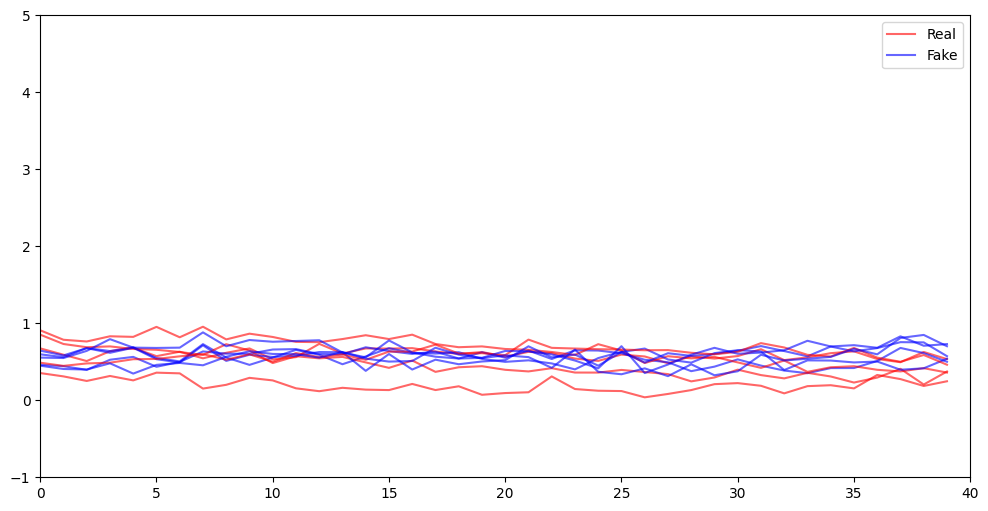

4/4 [==============================] - 0s 5ms/step
1000 epoch, Recognizing real data: 0.0 , Recognizing fake data: 1.0


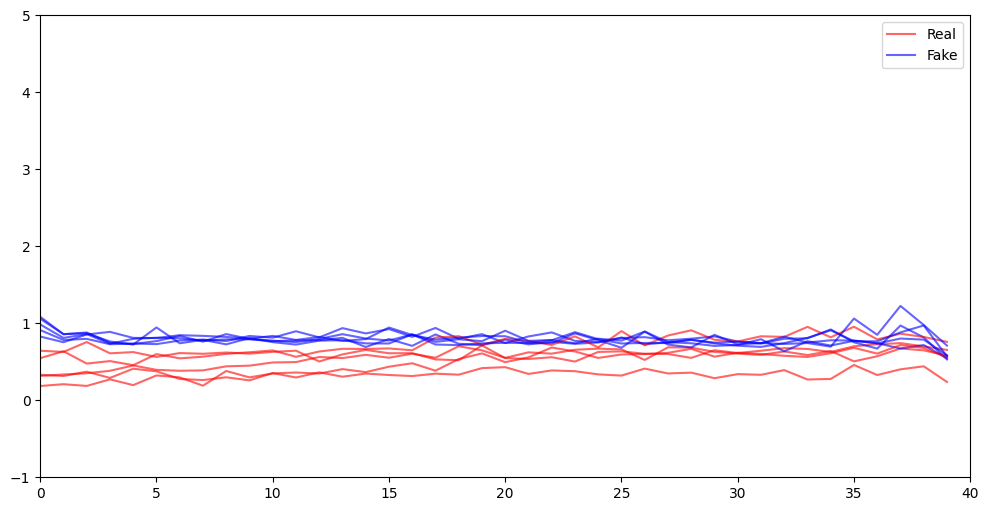

4/4 [==============================] - 0s 4ms/step
1010 epoch, Recognizing real data: 0.75 , Recognizing fake data: 0.009999999776482582


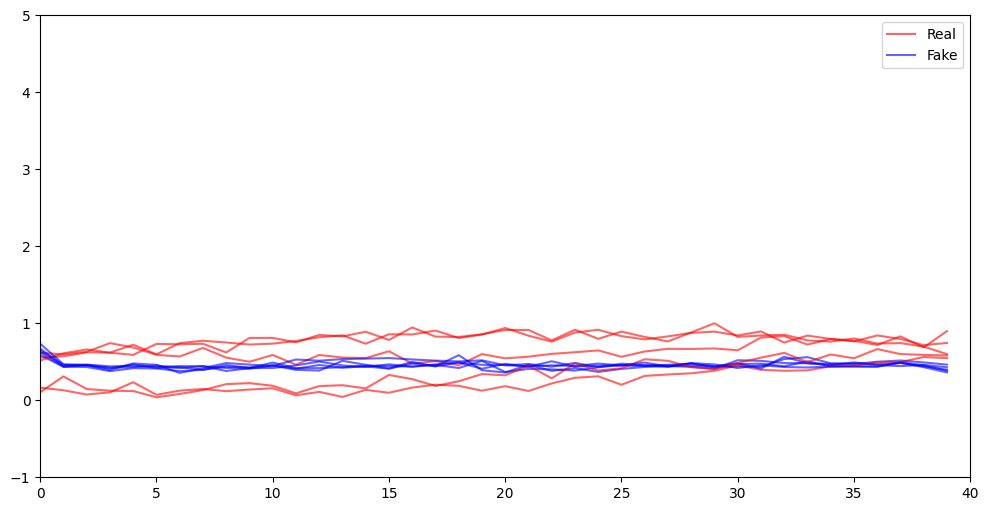

Stopping training


In [16]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, Dense, Flatten, TimeDistributed
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Define legacy Adam optimizer
from keras.optimizers.legacy import Adam as LegacyAdam

adam_optim = LegacyAdam(0.0002, 0.5)

# Define generator, discriminator, and GAN models (assuming these are defined earlier)
# Redefine them here for clarity

def define_generator(window_size, input_dim):
    model = Sequential()
    model.add(Conv1D(64, 3, input_shape=(window_size, input_dim), padding='same', activation='relu'))
    model.add(Conv1D(128, 3, padding='same', activation='relu'))
    model.add(Conv1D(256, 3, padding='same', activation='relu'))
    model.add(Conv1D(512, 3, padding='same', activation='relu'))
    model.add(TimeDistributed(Dense(input_dim, activation='linear')))
    return model

def define_discriminator(window_size, input_dim):
    model = Sequential()
    model.add(Conv1D(64, 3, input_shape=(window_size, input_dim), padding='same', activation='relu'))
    model.add(Conv1D(128, 3, padding='same', activation='relu'))
    model.add(Conv1D(256, 3, padding='same', activation='relu'))
    model.add(Conv1D(512, 3, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # the discriminator must be compiled to train it for classification
    model.compile(loss='binary_crossentropy', optimizer=adam_optim, metrics=['accuracy'])
    return model

def define_gan(generator, discriminator):
    # Make the discriminator not trainable when combined with the generator
    discriminator.trainable = False

    # Define the GAN input (noise) and the output
    gan_input = Input(shape=(generator.input_shape[1], generator.input_shape[2]))
    gen_output = generator(gan_input)
    gan_output = discriminator(gen_output)

    # Create the GAN model
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=adam_optim, metrics=['accuracy'])

    return gan

# Assuming the previous code to preprocess data and define get_real_samples, generate_latent_points, and get_fake_samples is the same

nb_epochs = 2000  # Number of epochs for training
eval_no = 10
acc_real, acc_fake = 0, 0
batch_size = 64

# Redefine the models
generator = define_generator(window_size, X.shape[2])
discriminator = define_discriminator(window_size, X.shape[2])
gan = define_gan(generator, discriminator)

for i in range(nb_epochs):
    # Generating and mixing real and fake data
    half_batch = batch_size // 2
    x_real, y_real = get_real_samples(half_batch, X)  # Get half the batch with real samples
    x_fake, y_fake = get_fake_samples(generator, half_batch, window_size, X.shape[2])  # Get half the batch with fake samples

    x_dis, y_dis = np.concatenate([x_real, x_fake]), np.concatenate([y_real, y_fake])
    perm = np.random.permutation(x_dis.shape[0])
    x_dis, y_dis = x_dis[perm], y_dis[perm]  # Shuffle the batch

    # Training the discriminator
    discriminator.train_on_batch(x_dis, y_dis)

    # Train the complete GAN with noise, discriminator is frozen
    # and 1 is predicted (forcing the generator to generate real-like data)
    x_gan = generate_latent_points(batch_size, window_size, X.shape[2])  # Generate batch sized latent points
    y_gan = np.ones((batch_size, 1))  # Define "real" labels for the fake input as target variable

    gan.train_on_batch(x_gan, y_gan)

    # Display of results and training stop criteria
    if (i % eval_no) == 0:
        acc_real, acc_fake = summarize_performance(i, generator, discriminator, X, window_size)

        # Training stop criteria
        if i > 1000 and acc_real > 0.7:
            print("Stopping training")
            break


At the end of the training let us check how discriminator works on the complete dataset:

In [17]:
preds = model_dis.predict(X)

30/30 [==============================] - 0s 2ms/step


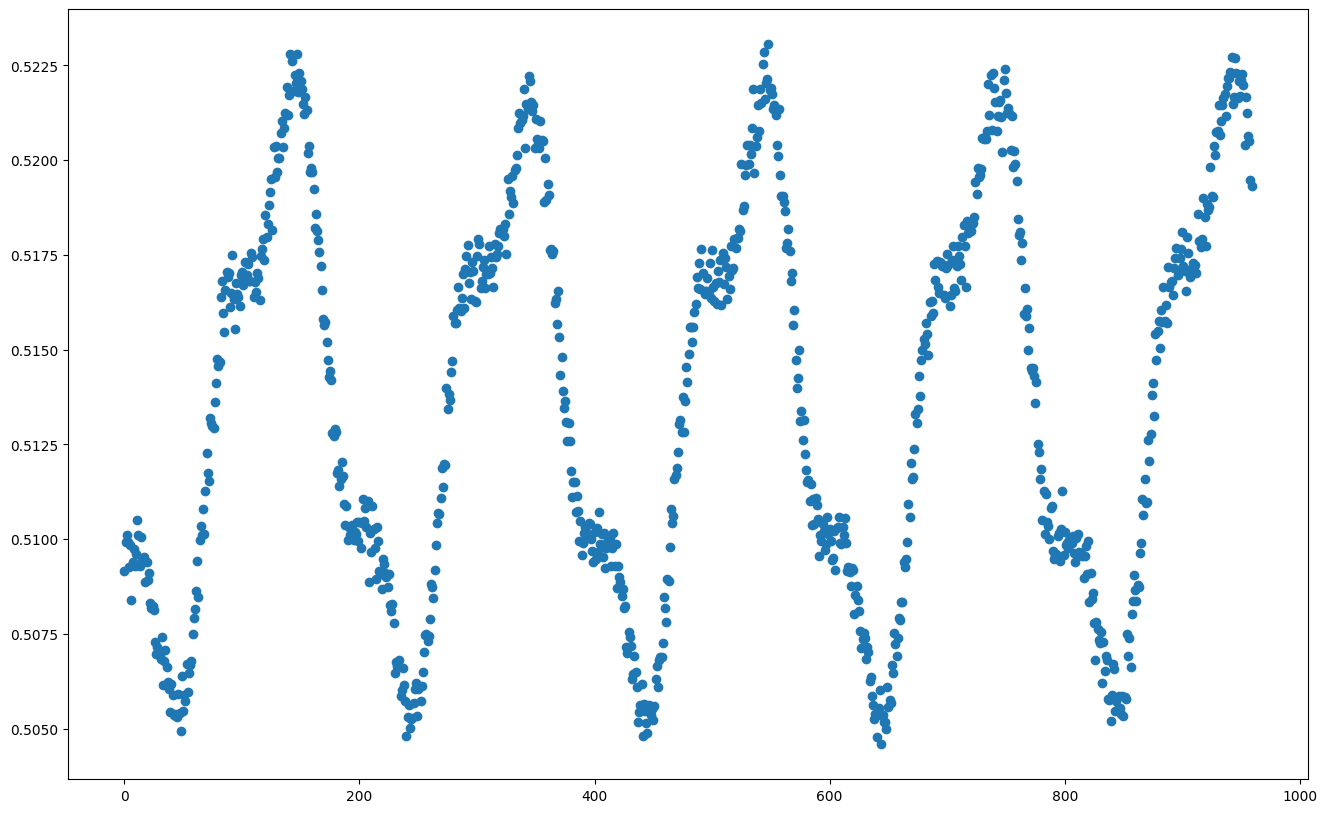

In [18]:
plt.figure(figsize=(16,10))
rng = np.arange(len(preds))
plt.scatter(rng, preds)

In [19]:
min_val, max_val = np.min(preds), np.max(preds)

## Anomaly detection
Add minimal anomalies to the data and try to detect them automatically using the trained discriminator:

In [20]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(42)

# Specify the number of anomalies
no_anomalies = 50  # Example number, adjust as needed

# Create an array of indices corresponding to the data points
anomaly_samples = np.arange(len(data))

# Shuffle the array to randomly select anomaly positions
np.random.shuffle(anomaly_samples)

# Select the first 'no_anomalies' elements as the positions of anomalies
anomaly_samples = anomaly_samples[:no_anomalies]

# Print the positions of anomalies in the data
print("The position of anomalies in the data:", anomaly_samples)

The position of anomalies in the data: [521 737 740 660 411 678 626 513 859 136 811  76 636 973 938 899 280 883
 761 319 549 174 371 527 210 235 101 986 902 947 346 139 621 499 370 198
 687 584 901  59 328  96 312 974 299 277 924 601 439 837]


In [21]:
anomaly_length = 2
anomaly_data = copy.copy(data)
for start in anomaly_samples:
    anomaly_data[start:start+anomaly_length] = anomaly_data[start:start+anomaly_length]/((np.random.rand(anomaly_length)+1)*4)

X_anomaly = np.array( [ anomaly_data[start:start+window_size] for start in range(0,len(anomaly_data)-window_size)] )
X_anomaly = np.atleast_3d(X_anomaly)

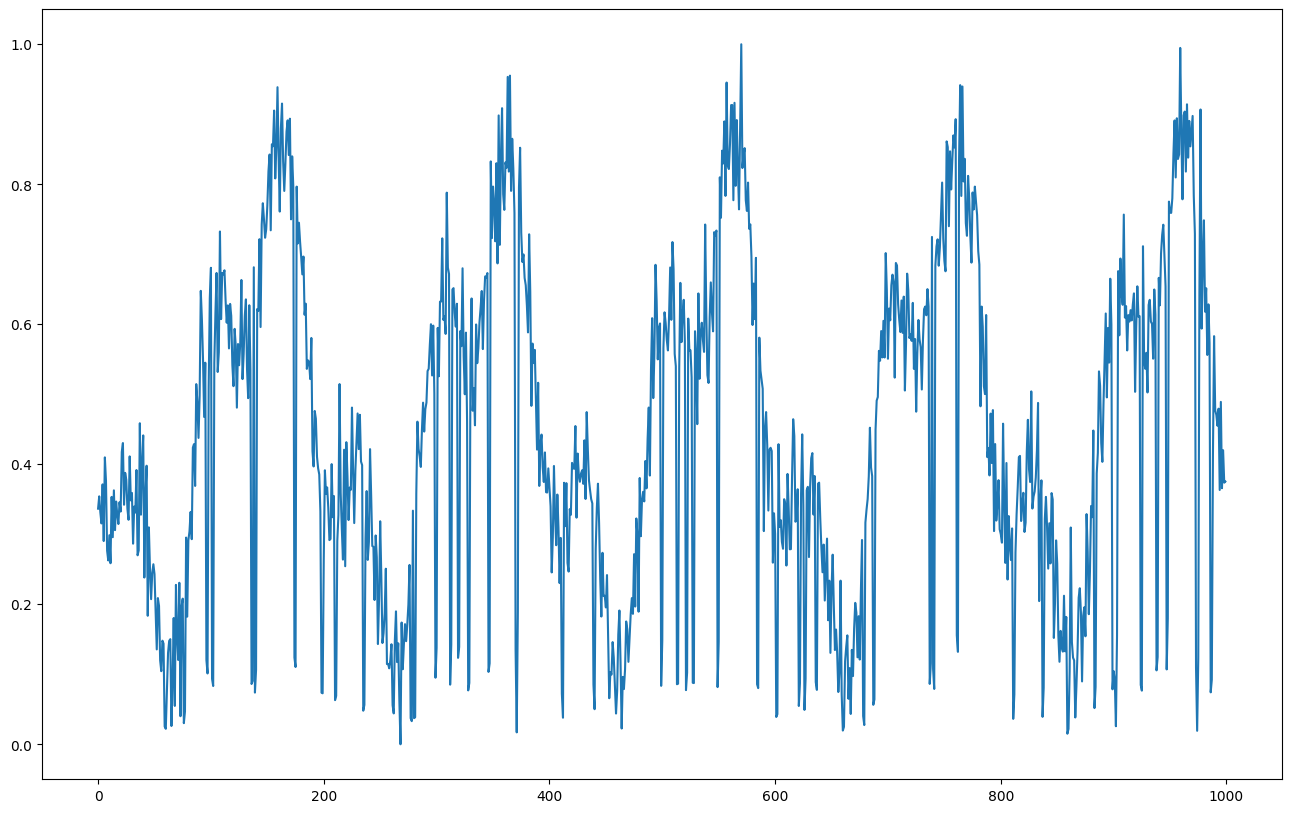

In [22]:
plt.figure(figsize=(16,10))
plt.plot(anomaly_data)

Anomalies in the real data stream are hard to spot, so let's see how GAN performs:

In [23]:
preds = model_dis.predict(X_anomaly)

30/30 [==============================] - 0s 3ms/step


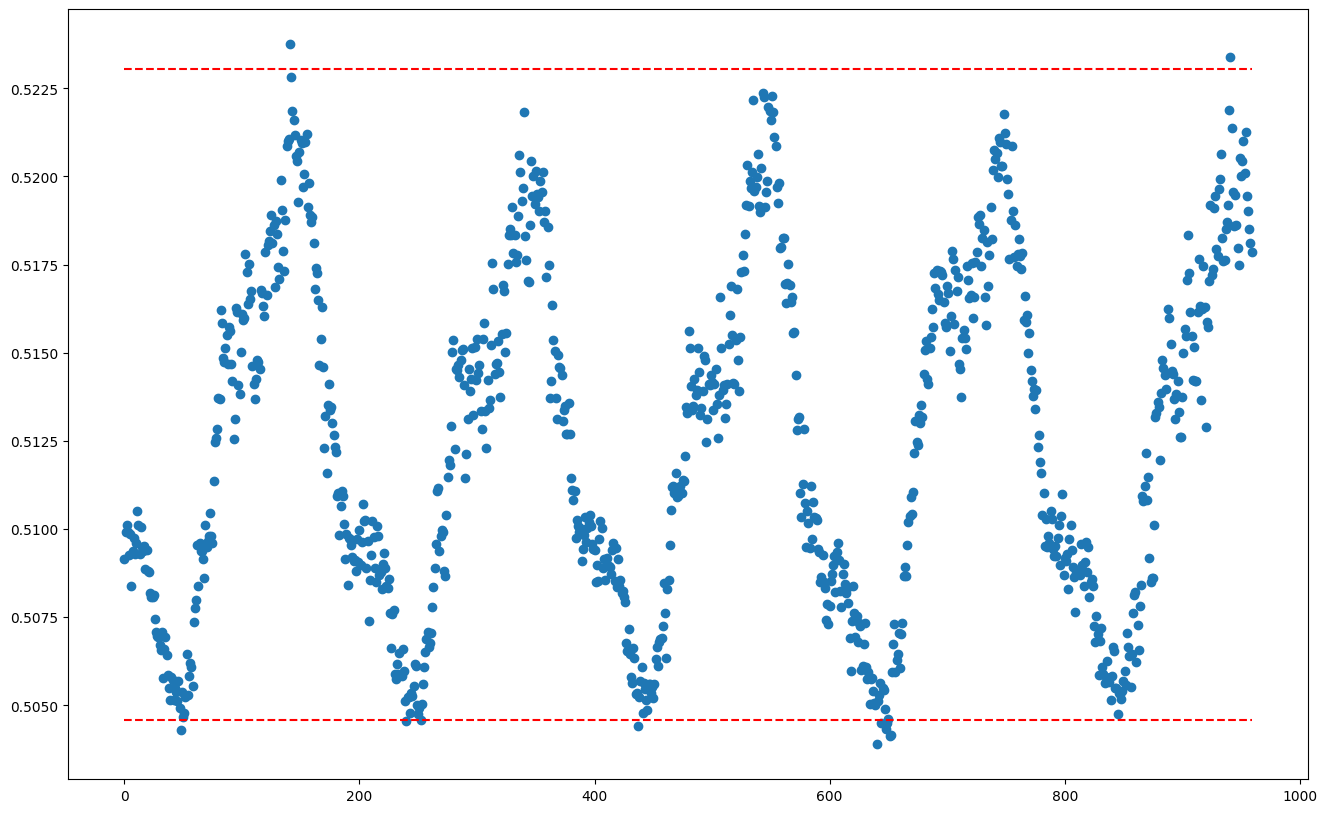

In [24]:
plt.figure(figsize=(16,10))
rng = np.arange(len(preds))
plt.scatter(rng, preds)
horiz_line_min = np.array([min_val for i in range(len(preds))])
horiz_line_max = np.array([max_val for i in range(len(preds))])
plt.plot(rng, horiz_line_min, 'r--')
plt.plot(rng, horiz_line_max, 'r--')

The GAN results should be observed for deviations in the positive or negative direction from the previous band. In this case, the anomalies are nicely highlighted: the first more pronounced in the negative direction, the second less pronounced, also in the negative direction.